In [1]:
import numpy as np
import pandas as pd

# import rdkit and rdkit functions for cheminformatics
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

# import logging for debugging
import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)

# import skunk for workflow management
try:
    import skunk
except ImportError:
    !pip install skunk
    import skunk

# import matplotlib and seaborn for plotting
import matplotlib. pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn2
import seaborn as sns

# import cairosvg for svg to png conversion
try:
    import cairosvg
except ImportError:
    !pip install cairosvg
    import cairosvg

# import pythia modules for data analysis
from pythia import molecules_and_structures as mi

# Loading Data

First, we load the data from a CSV file. The data is stored in a pandas DataFrame. We reformat the columns to make them easier to work with.

In [2]:
data = pd.read_csv("../dataset_ise.csv", encoding='utf-8')
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

Convert the SMILES collected into canonical SMILES and save them to a new column.

In [3]:
data['canonical_smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles)) for smiles in data['smiles']]

Create a new column called 'target' to define the target variable as the log10 of EC50 values of transport activity.

In [4]:
data['target'] = np.log10(data['ec50(mol%)_raw'])

`dataframe.head()` is used to display the first 5 rows of the dataframe. This is useful to quickly check if the data has been loaded correctly.

In [5]:
data.head()

entry_in_paper                                   smiles anion  \
0              1             S=C(NCCCCCC)NC1=CC=C(Br)C=C1    Cl   
1              2       S=C(NCCCCCC)NC1=CC=C(C(F)(F)F)C=C1    Cl   
2              3             S=C(NCCCCCC)NC1=CC=C(Cl)C=C1    Cl   
3              4            S=C(NCCCCCC)NC1=CC=C(C#N)C=C1    Cl   
4              5  S=C(NCCCCCC)NC1=CC=C(C(C(F)(F)F)=O)C=C1    Cl   

   binding_mode\n(transporter)  binding_mode\n(anion)  \
0                          1.0                    1.0   
1                          1.0                    1.0   
2                          1.0                    1.0   
3                          1.0                    1.0   
4                          1.0                    1.0   

   stochiometry\n(#_of_anion_\nper_transporter) nmr_solvent ka_(_m-1)  \
0                                           1.0        DMSO     18.62   
1                                           1.0        DMSO      26.3   
2                                           1.0        DMSO     19.95   
3                                           1.0        DMSO     31.62   
4                                           1.0        DMSO     41.69   

      assay lipid  ... assay_ph time_between_transporter_added_and_lysis_(s)  \
0  Cl-/NO3-  POPC  ...      7.2                                          270   
1  Cl-/NO3-  POPC  ...      7.2                                          270   
2  Cl-/NO3-  POPC  ...      7.2                                          270   
3  Cl-/NO3-  POPC  ...      7.2                                          270   
4  Cl-/NO3-  POPC  ...      7.2                                          270   

   ec50(mol%)_raw  ec50(mol%)_target  hill_parameter_n  paperid  year  \
0            0.93               0.93               NaN        1  2013   
1            0.44               0.44              1.65        1  2013   
2            1.02               1.02              1.57        1  2013   
3            0.82               0.82              2.11        1  2013   
4            0.93               0.93              1.93        1  2013   

                                                 ref  \
0  Towards predictable transmembrane transport: Q...   
1  Towards predictable transmembrane transport: Q...   
2  Towards predictable transmembrane transport: Q...   
3  Towards predictable transmembrane transport: Q...   
4  Towards predictable transmembrane transport: Q...   

                       canonical_smiles    target  
0             CCCCCCNC(=S)Nc1ccc(Br)cc1 -0.031517  
1       CCCCCCNC(=S)Nc1ccc(C(F)(F)F)cc1 -0.356547  
2             CCCCCCNC(=S)Nc1ccc(Cl)cc1  0.008600  
3            CCCCCCNC(=S)Nc1ccc(C#N)cc1 -0.086186  
4  CCCCCCNC(=S)Nc1ccc(C(=O)C(F)(F)F)cc1 -0.031517  

[5 rows x 23 columns]

# Dataset visualization
Here we will visualize the 2D chemical structure of the molecules in the dataset. 

Source: https://gist.github.com/adelenelai/beed325f06a23f7ebc491903f171757f

First, we define the list of SMILES strings for the molecules of interest and target variable.

In [6]:
smiles = data['canonical_smiles']
target = data["target"]

Create RDKIT molecules from the SMILES strings.

In [7]:
mols = [Chem.MolFromSmiles(m) for m in smiles]

The cell below draw a list of molecules in a grid.

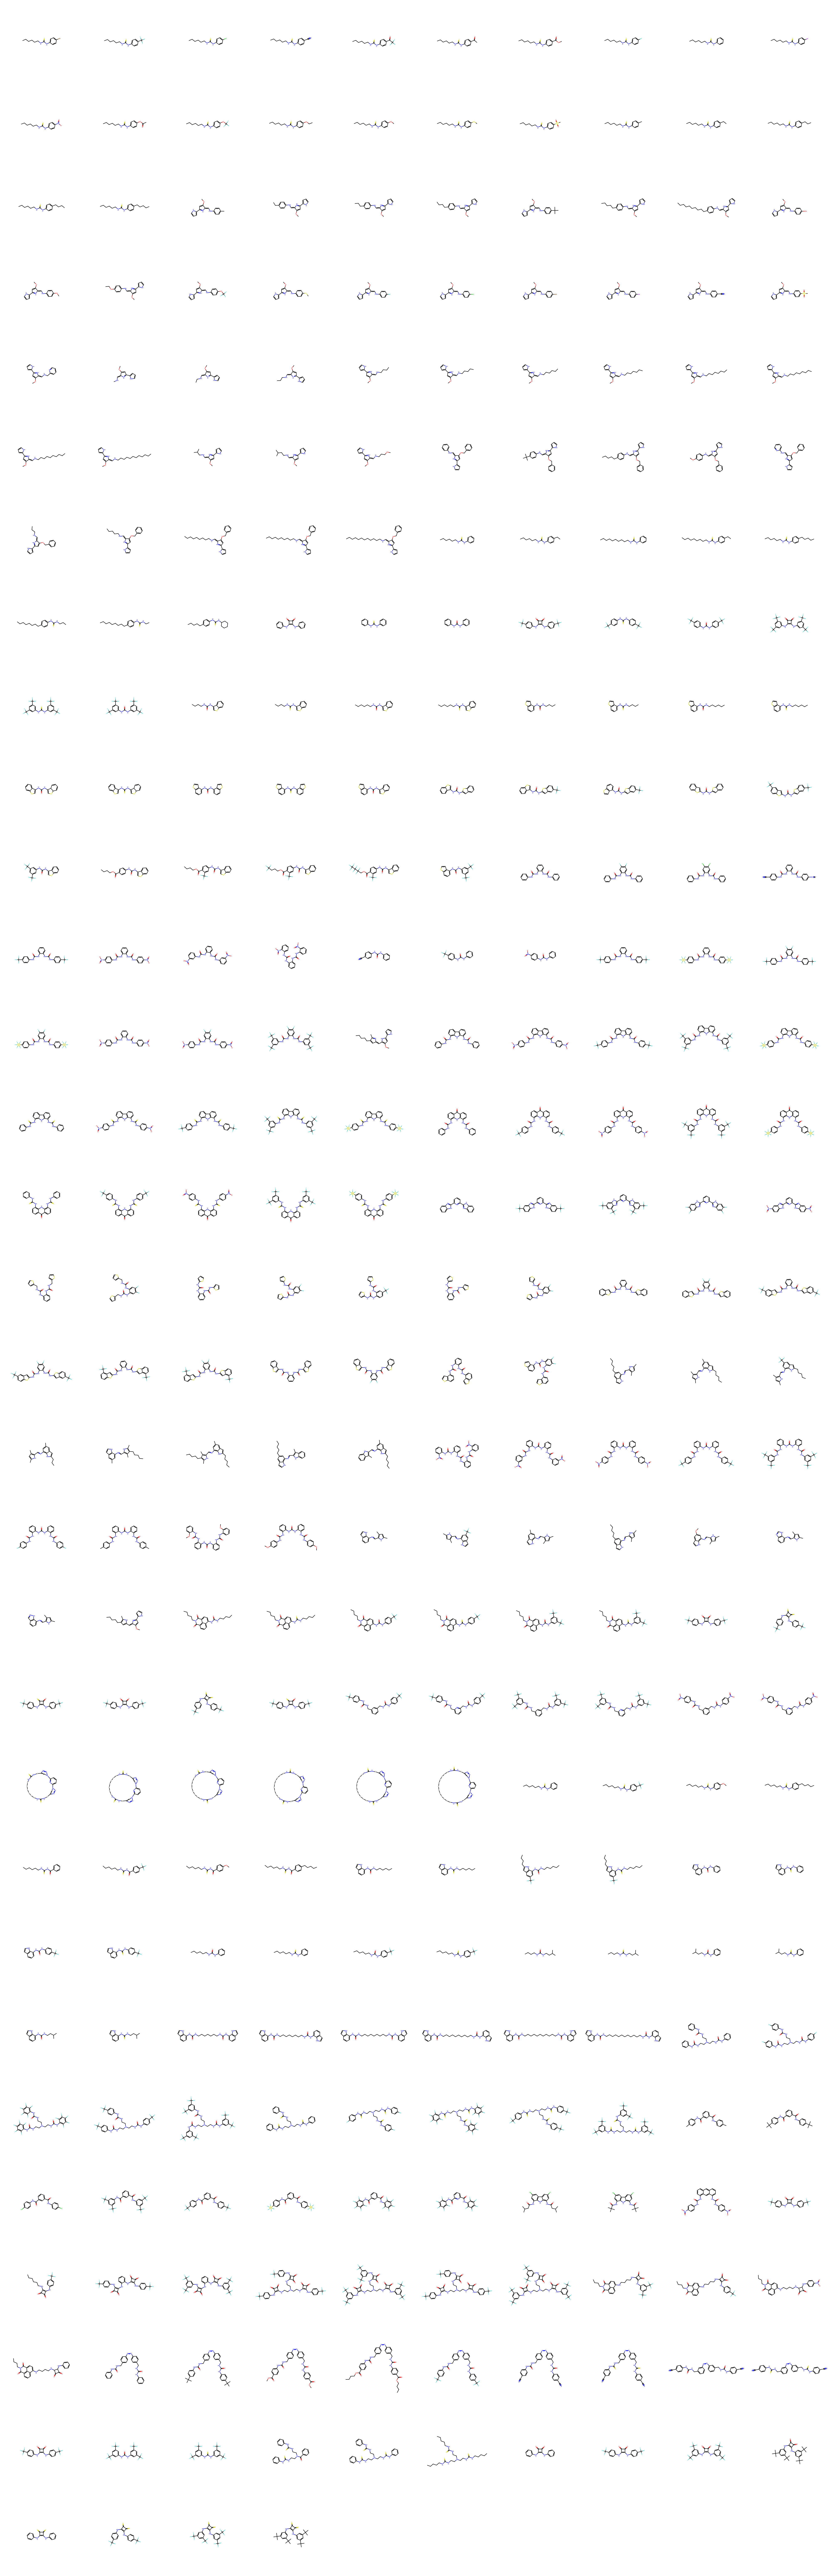

In [8]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=10, subImgSize=(400, 400), maxMols=len(mols))

# Tanimoto similarity across the dataset

The Tanimoto matrix is a square matrix with the Tanimoto index between each pair of molecules in the dataset. The diagonal of the matrix is always 1, since the Tanimoto index of a molecule with itself is 1.

Here we plot the Tanimoto matrix for the dataset using the ***mi.tanimoto_plot*** function. The function takes as input the SMILES of the molecules in the dataset. The function returns the average and standard deviation of the Tanimoto index across the dataset, a plot of the Tanimoto matrix, and a dataframe with the Tanimoto index between each pair of molecules in the dataset.


mean:  0.20957375648889925
std:  0.14525681851789202


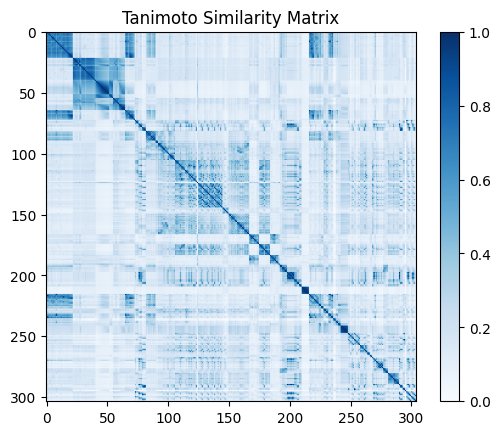

In [9]:
fps = [AllChem.GetMorganFingerprint(m,2) for m in mols]
smiles_canonical = [Chem.MolToSmiles(m) for m in mols]

# the list for the dataframe
qu, ta, sim = [], [], []
qu_n, ta_n = [], []

# compare all fp pairwise without duplicates
for n in range(len(fps)-1): # -1 so the last fp will not be used
    s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp

    # collect the SMILES and values
    for m in range(len(s)):
        qu_n.append(n)
        ta_n.append(m)
        qu.append(smiles_canonical[n])
        ta.append(smiles_canonical[n+1:][m])
        sim.append(s[m])
print()

# build the dataframe and sort it
d = {'query':qu, 'target':ta, 'Similarity':sim}
df_final = pd.DataFrame(data=d)

dlabel = {'query':qu_n, 'target':ta_n, 'Similarity':sim}
df_label_final = pd.DataFrame(data=dlabel)


# save as csv
df_final.to_csv('fingerprints.csv', index=False, sep=',')
df_label_final.to_csv('fingerprints_label.csv', index=False, sep=',')

# visualize structural similarity
similarity_array = np.zeros(shape=(len(fps), len(fps)))

# compare all fp pairwise without duplicates
for n, fp in enumerate(fps): # -1 so the last fp will not be used
    s = DataStructs.BulkTanimotoSimilarity(fp, fps)
    similarity_array[n, :] = np.array(s)

# print mean and std of the similarity array
print('mean: ', np.mean(similarity_array))
print('std: ', np.std(similarity_array))

im = plt.imshow(similarity_array,cmap='Blues')
plt.title('Tanimoto Similarity Matrix')
plt.colorbar(im, spacing = 'uniform')
plt.clim(0, 1)
plt.savefig('fig_similarity.png', dpi=300)
plt.show()

# Chemical space visualization

The methods for chemical space visualization covered are:
1. PCA
2. t-SNE
3. UMAP

This section is based on the following articles/notebooks:
* http://practicalcheminformatics.blogspot.com/2019/11/visualizing-chemical-space.html
* https://blog.reverielabs.com/mapping-chemical-space-with-umap/
* https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html

In [10]:
# For data manipulation
from tqdm import tqdm

# For PCA
from sklearn.decomposition import PCA

# For t-SNE
from sklearn.manifold import TSNE

# For UMAP
try:
    import umap.umap_ as umap
except ImportError:
    !pip install umap-learn
    import umap.umap_ as umap

2024-07-01 18:32:54.839278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

fp_list = fp_list_from_smiles_list(smiles)

100%|██████████| 304/304 [00:00<00:00, 2677.67it/s]


## PCA

Principal component analysis (PCA) is a dimensionality reduction technique that can be used to reduce the number of features in a dataset. It does this by finding the principal components of the dataset, which are the directions of maximum variance. The first principal component is the direction of maximum variance, the second principal component is the direction of maximum variance orthogonal to the first principal component, and so on. The principal components are orthogonal to each other.

PCA can be done using sckit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.

To visualise the dataset in 2D set the n_components to 2 (but if you're only using PCA for dimensionality reduction for ML the n_components should be higher).

In [12]:
%%time

# Define the PCA model with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the fingerprints 
X_pca = pca.fit_transform(fp_list)

# Create a dataframe with the 2 principal components
pca_df = pd.DataFrame(X_pca,columns=["PC1","PC2"])

# Display the first 5 rows of the dataframe
pca_df.head()

CPU times: user 55.2 ms, sys: 19.2 ms, total: 74.4 ms
Wall time: 24.3 ms


PC1       PC2
0  0.202336  3.488843
1 -0.534281  3.088148
2  0.117627  3.517881
3  0.193068  3.486549
4 -0.332204  3.157694

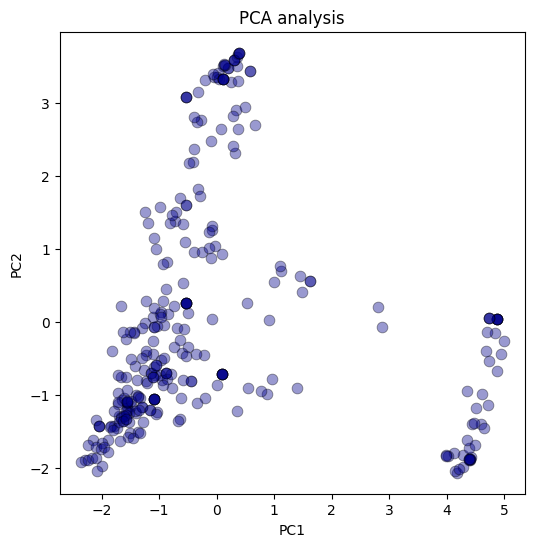

In [13]:
# Plot PCA results
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('PCA analysis')
ax = sns.scatterplot(data=pca_df,x="PC1",y="PC2",color='darkblue', s=60, alpha=0.4, edgecolor='k')
fig.savefig('fig_visualize_pca.png', dpi=300, bbox_inches='tight')

## t-SNE
t-SNE is a non-linear dimensionality reduction algorithm that is well suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

t-SNE is also implemented in sckit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html.

Better and quicker results are achieved when PCA is used first to reduced the dataset dimensions to n_components=50.

In [14]:
%%time

# First use PCA to reduce the dimensionality of the data
pca = PCA(n_components=50)
X_pca = pca.fit_transform(fp_list) 

# Then use t-SNE to further reduce the dimensionality
X_embedded = TSNE(n_components=2).fit_transform(X_pca)

CPU times: user 3.1 s, sys: 281 ms, total: 3.38 s
Wall time: 840 ms


In [15]:
# Create a dataframe from the embedded features (TSNE1, TSNE2)
tsne_df = pd.DataFrame(X_embedded,columns=["TSNE1","TSNE2"])

# Display the first 5 rows of the dataframe
tsne_df.head()

TSNE1     TSNE2
0  10.255755 -0.553381
1   6.510623 -3.810494
2   9.436856 -0.121548
3  11.033388 -4.101140
4   8.477521 -3.258940

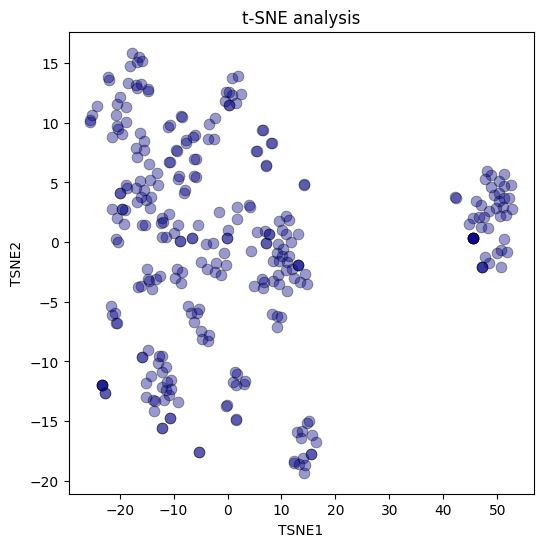

In [16]:
# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('t-SNE analysis')
ax = sns.scatterplot(data=tsne_df,x="TSNE1",y="TSNE2",color='darkblue', s=60, alpha=0.4, edgecolor='k')
fig.savefig('fig_visualize_tsne.png', dpi=300, bbox_inches='tight')

## UMAP

UMAP is a dimensionality reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. It is based on Riemannian geometry and algebraic topology.

Ref: https://umap-learn.readthedocs.io/en/latest/basic_usage.html

The n_neighbors parameter can be adjusted to focus on local (decrease) vs global (increase) structure in the data.

In [17]:
%%time

# Define the UMAP model
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 20,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)

# Fit the UMAP model to the data
X_umap = umap_model.fit_transform(fp_list)

/Users/allybo/opt/anaconda3/envs/pythiachem/lib/python3.9/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 8.97 s, sys: 305 ms, total: 9.27 s
Wall time: 6.36 s


In [18]:
# Create a dataframe with the UMAP coordinates
umap_df = pd.DataFrame({'UMAP1': X_umap[:,0], 'UMAP2': X_umap[:,1]})

# Display the first five rows of the dataframe
umap_df.head()

UMAP1     UMAP2
0 -5.773156 -2.060095
1 -5.699628 -2.616308
2 -5.740498 -1.986625
3 -5.784225 -1.977025
4 -5.886794 -2.505982

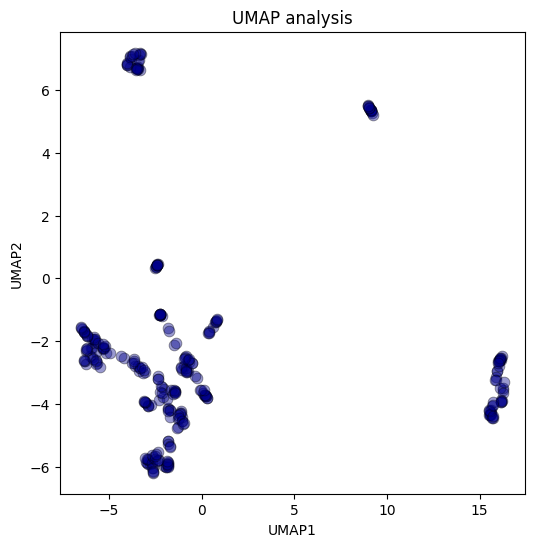

In [19]:
# Plot the UMAP results
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('UMAP analysis')
ax = sns.scatterplot(data=umap_df,x="UMAP1",y="UMAP2",color='darkblue', s=60, alpha=0.4, edgecolor='k')
fig.savefig('fig_visualize_umap.png', dpi=300, bbox_inches='tight')

# Target distribution

Here we plot the distribution of the target variable. 

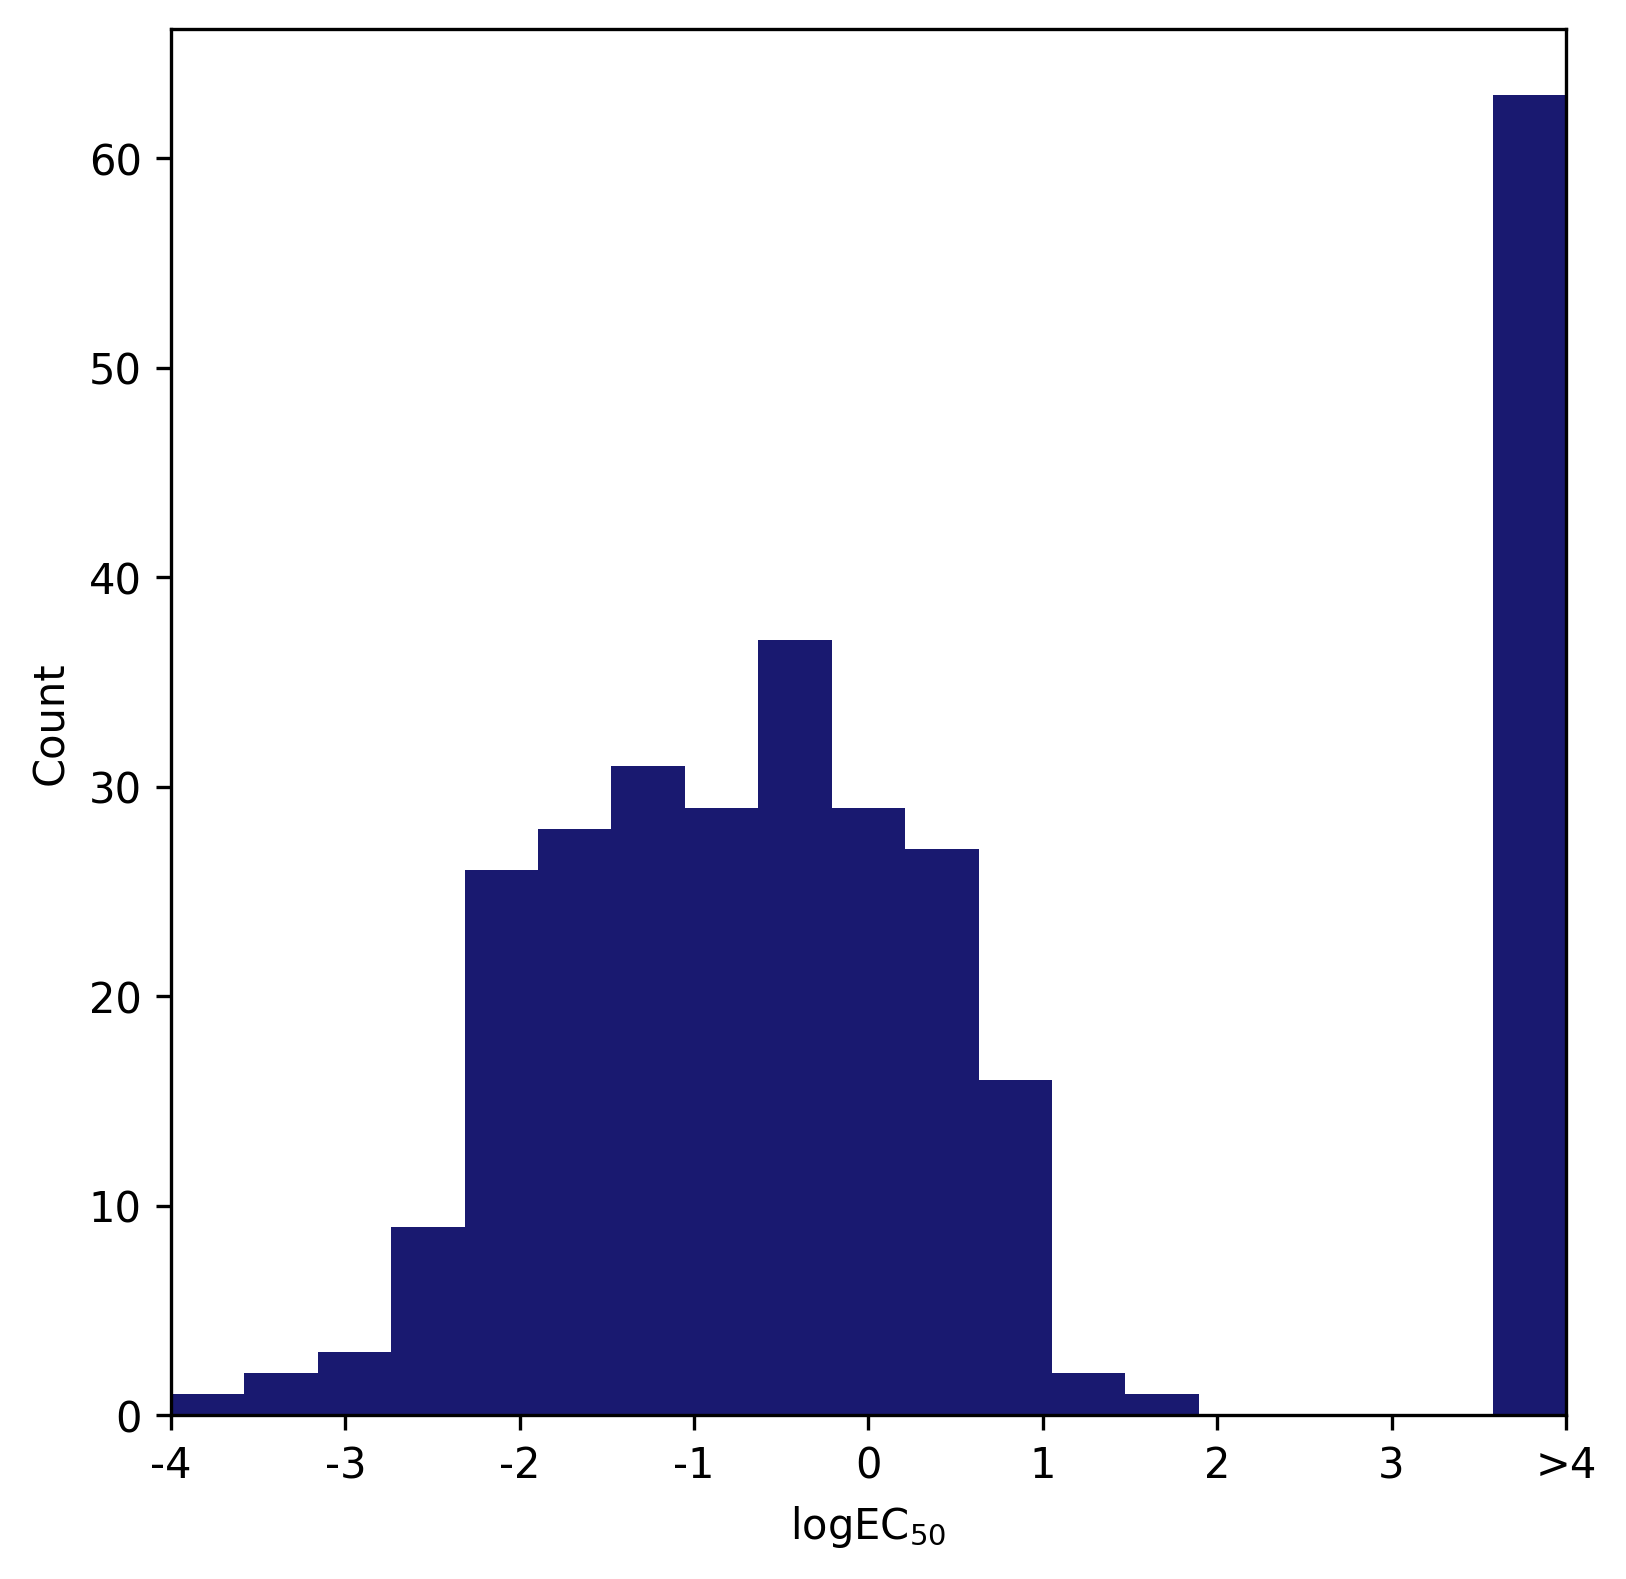

In [20]:
#fig, ax = plt.subplots(figsize=(6,6))

fig, ax = plt.subplots(figsize=(6,6), dpi=300)
bins = np.linspace(-4, 4, 20)
target_to_plot = data['target'].fillna('100').astype(float)
ax.hist(np.clip(target_to_plot, bins[0], bins[-1]), color='midnightblue', bins = bins, density=False)
plt.xlim(-4, 4)
plt.xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
ax.set_xticklabels([-4, -3, -2, -1, 0, 1, 2, 3, '>4'])
ax.set_xlabel('logEC$_{50}$')
ax.set_ylabel('Count')
#ax.set_title('logEC$_{50}$ distribution')

fig.savefig('fig_logEC50_distribution.png', dpi=300, bbox_inches='tight')

# Class distribution

if logEC50 < 0, class 1

if logEC50 >= 0, class 0

In [21]:
data['class'] = np.where(data['target'] < 0, 1, 0)
data['class'].value_counts()

1    177
0    127
Name: class, dtype: int64

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_89826/1068482027.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'class', data = data, palette = 'Blues')
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/_g/b42gzqq15333k7_yvwzzfxzr0000gp/T/ipykernel_89826/1068482027.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Inactive', 'Active'])


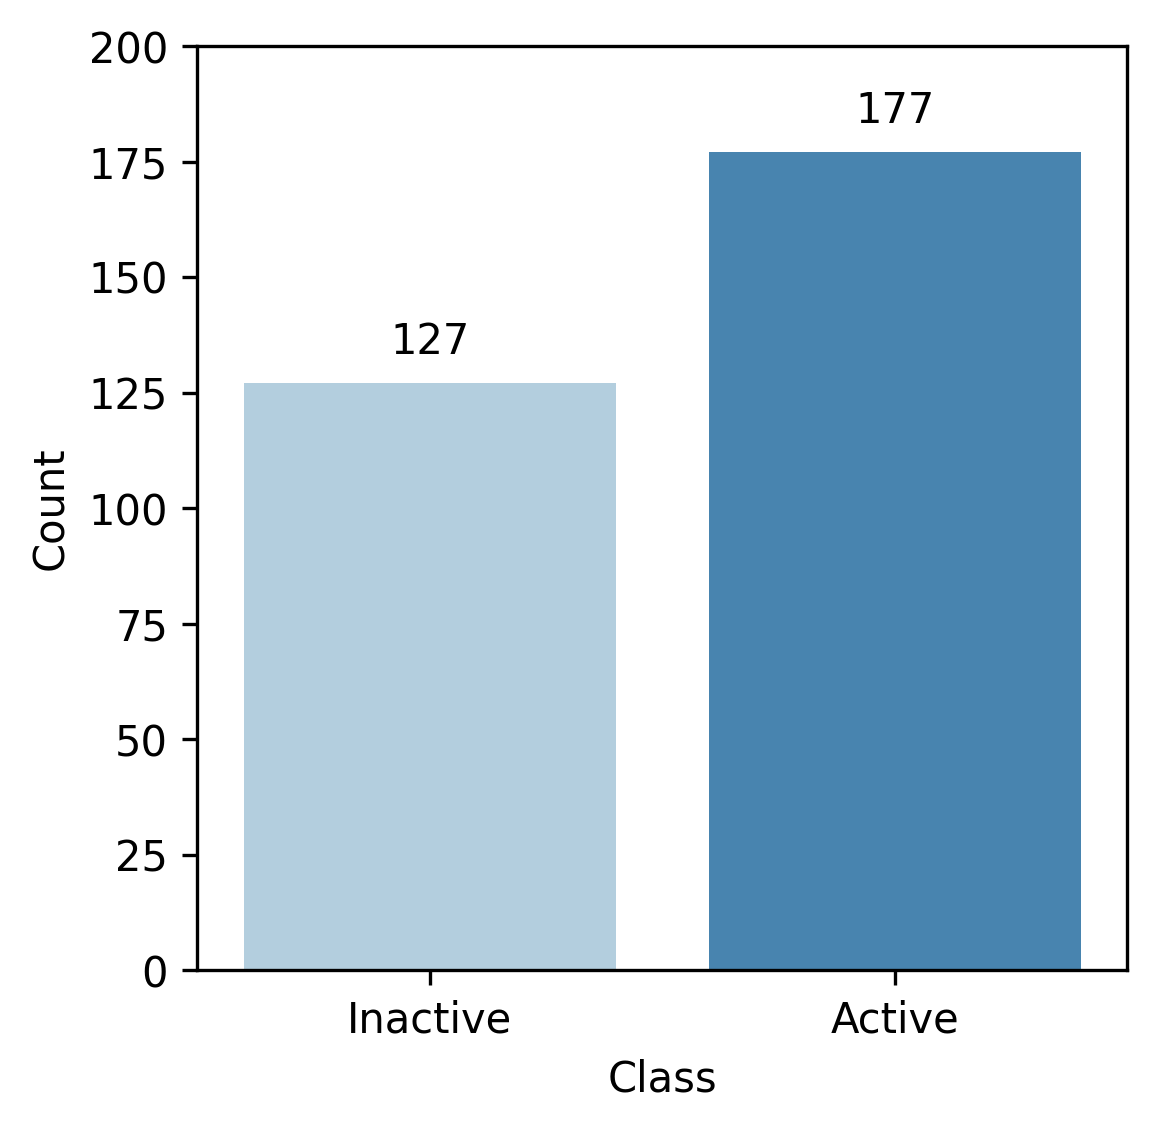

In [22]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.countplot(x = 'class', data = data, palette = 'Blues')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_ylim(0, 200)
ax.set_xticklabels(['Inactive', 'Active'])
#ax.set_title('entire dataset (n = {})'.format(str(len(data))))
# show counts on the bars
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig.savefig('fig_y_class_entire_dataset.png', dpi=300)

# Advanced analysis (optional)

For this anion transporter dataset, there are some common binding motifs that are known to be important for anion binding. These include the following:
- thiourea
- urea
- squaramide
- tambjamine
- carbazole
- perenosin
- indole
- acridinone
- 1,3-bis(benzimidazol-2-yl)pyrimidine (BisBzImPy)
- isophthalamides/dipicolineamides.

In the following section, we demonstrate how to perform substructure matching to generate substructure datasets for each of these motifs. We then investigate the occurance of each motif in the dataset, overlap between motifs, and the structural diversity and target distribution within each substructure dataset.


The cell below showcases a function to collect the substructure matches of a query substructure SMARTS in a list of molecules.

To learn more about SMARTS: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html

In [23]:
def get_match(patterm_mol, mols):
    matches = []
    indices = []

    patt = patterm_mol
    for i, mol in enumerate(mols):
        if mol.HasSubstructMatch(patt):
            indices.append(i)
            matches.append(mol)
    return matches, indices

## Thioureas

We first define the SMARTS for thioureas and then collect the substructure matches in the molecules of interest.

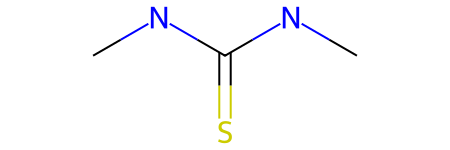

In [24]:
patt_thiourea = Chem.MolFromSmarts(Chem.MolToSmarts(Chem.MolFromSmiles('S=C(NC)NC')))
patt_thiourea

In [25]:
matches_thiourea, indices_thiourea = get_match(patt_thiourea, mols)
print(len(matches_thiourea))

86


## Urea

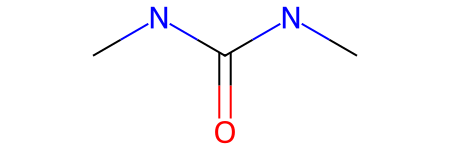

In [26]:
patt_urea = Chem.MolFromSmarts(Chem.MolToSmarts(Chem.MolFromSmiles('O=C(NC)NC')))
patt_urea

In [27]:
matches_urea, indices_urea = get_match(patt_urea, mols)
print(len(matches_urea))

113


## Squaramide

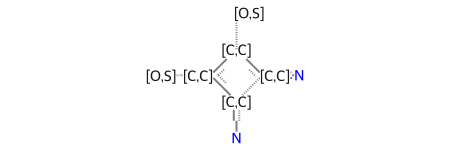

In [28]:
patt_squara = Chem.MolFromSmarts('N[C,c]1~[C,c](N)[C,c]([C,c]1~[O,S])~[O,S]')
patt_squara

In [29]:
matches_squara, indices_squara = get_match(patt_squara, mols)
print(len(matches_squara))

30


## Tambjamine

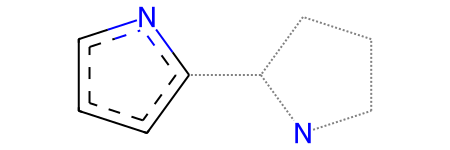

In [30]:
patt_tamb = Chem.MolFromSmarts('[#6]1~[#6]~[#6]~[#6](~[#6]2:[#6]:[#6]:[#6]:[#7H]:2)~[#7]~1')
patt_tamb

In [31]:
matches_tamb, indices_tamb = get_match(patt_tamb, mols)
print(len(matches_tamb))


45


## Carbazole

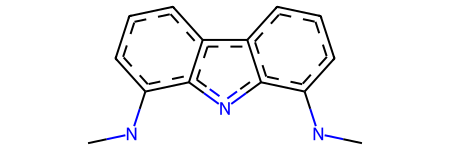

In [32]:
patt_carbazole = Chem.MolFromSmarts(Chem.MolToSmarts(Chem.MolFromSmiles('CNC1=CC=CC2=C1NC3=C2C=CC=C3NC')))
patt_carbazole

In [33]:
matches_carbazole, indices_carbazole = get_match(patt_carbazole, mols)
print(len(matches_carbazole))

12


## Perenosin

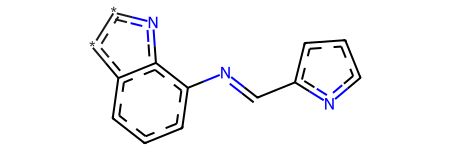

In [34]:
patt_pere = Chem.MolFromSmarts('[#6]12:[*]:[*]:[#7H]:[#6]:1:[#6](/[#7]=[#6]/[#6]1:[#6]:[#6]:[#6]:[#7H]:1):[#6]:[#6]:[#6]:2')
patt_pere

In [35]:
matches_pere, indices_pere = get_match(patt_pere, mols)
print(len(matches_pere))

15


## Indole

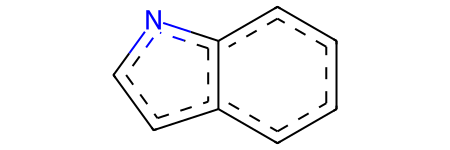

In [36]:
patt_indole = Chem.MolFromSmarts(Chem.MolToSmarts(Chem.MolFromSmiles('C1(C=CC=C2)=C2NC=C1')))
patt_indole

In [37]:
matches_indole, indices_indole = get_match(patt_indole, mols)
print(len(matches_indole))

41


## Acridinone

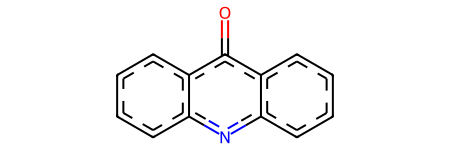

In [38]:
patt_acridinone = Chem.MolFromSmarts(Chem.MolToSmarts(Chem.MolFromSmiles('O=C1C2=C(C=CC=C2)NC3=C1C=CC=C3')))
patt_acridinone

In [39]:
matches_acridinone, indices_acridinone = get_match(patt_acridinone, mols)
print(len(matches_acridinone))

10


## 1,3-bis(benzimidazol-2-yl)pyrimidine (BisBzImPy)

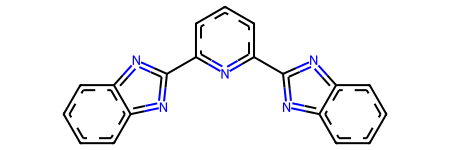

In [40]:
patt_BBP = Chem.MolFromSmarts(Chem.MolToSmarts(Chem.MolFromSmiles('C1(C2=NC(C=CC=C3)=C3N2)=CC=CC(C4=NC5=C(C=CC=C5)N4)=N1')))
patt_BBP

In [41]:
matches_BBP, indices_BBP = get_match(patt_BBP, mols)
print(len(matches_BBP))

5


## isophthalamides/dipicolineamides

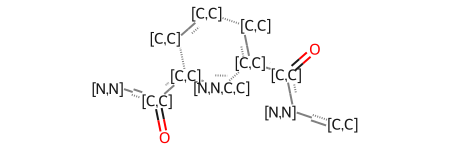

In [42]:
patt_isop_dipico = Chem.MolFromSmarts('O=[C,c]([N,n][C,c])[C,c]1~[N,n,C,c][C,c]([C,c]([N,n])=O)~[C,c][C,c]~[C,c]1')
patt_isop_dipico

In [43]:
matches_isop_dipico, indices_isop_dipico = get_match(patt_isop_dipico, mols)
print(len(matches_isop_dipico))

8


# Find overlap between substructure datasets

First we collect the substructure matches for each substructure in the molecules of interest.

In [44]:
# Disctionary: substructure pattern : list of RDKit molecules
substructure_dict = {'thiourea': matches_thiourea, 
                     'urea': matches_urea, 
                     'squaramide': matches_squara, 
                     'indole': matches_indole, 
                     'tambjamine': matches_tamb, 
                     'carbazole': matches_carbazole, 
                     'acridinone': matches_acridinone, 
                     'perenosin': matches_pere,
                     'BisBzImPy': matches_BBP, 
                     'isophthalamides/dipicolineamides': matches_isop_dipico}

# List of substructure patterns from SMARTS
substructure_core_list = [patt_thiourea, 
                         patt_urea, 
                         patt_squara, 
                         patt_indole, 
                         patt_tamb, 
                         patt_carbazole, 
                         patt_acridinone, 
                         patt_pere,
                         patt_BBP, 
                         patt_isop_dipico]

# List of substructure names
substructure_name_list = ['thiourea',
                     'urea', 
                     'squaramide', 
                     'indole', 
                     'tambjamine', 
                     'carbazole', 
                     'acridinone', 
                     'perenosin',
                     'BisBzImPy', 
                     'isophthalamides/dipicolineamides']
n_substructure = len(substructure_name_list)

# Convert list of RDKit molecules to list to canonical smiles
matches_thiourea_smi = [Chem.MolToSmiles(m) for m in matches_thiourea]
matches_urea_smi = [Chem.MolToSmiles(m) for m in matches_urea]
matches_squara_smi = [Chem.MolToSmiles(m) for m in matches_squara]
matches_indole_smi = [Chem.MolToSmiles(m) for m in matches_indole]
matches_tamb_smi = [Chem.MolToSmiles(m) for m in matches_tamb]
matches_carbazole_smi = [Chem.MolToSmiles(m) for m in matches_carbazole]
matches_acridinone_smi = [Chem.MolToSmiles(m) for m in matches_acridinone]
matches_pere_smi = [Chem.MolToSmiles(m) for m in matches_pere]
matches_BBP_smi = [Chem.MolToSmiles(m) for m in matches_BBP]
matches_isop_dipico_smi = [Chem.MolToSmiles(m) for m in matches_isop_dipico]

# List of lists of smiles with each substructure pattern
substructure_smi_list = [matches_thiourea_smi, 
                         matches_urea_smi, 
                         matches_squara_smi, 
                         matches_indole_smi, 
                         matches_tamb_smi, 
                         matches_carbazole_smi, 
                         matches_acridinone_smi, 
                         matches_pere_smi,
                         matches_BBP_smi, 
                         matches_isop_dipico_smi]

# Convert list of lists of smiles with each substructure pattern 
#to a list of sets of smiles with each substructure pattern
substructure_set_list = []
for i in range(n_substructure):
    substructure_set_list.append(set(substructure_smi_list[i]))

In [45]:
print('Substructure', '#molecules')
for n, l in substructure_dict.items():
    print(n, len(l))
    substructure_set = set(l)

Substructure #molecules
thiourea 86
urea 113
squaramide 30
indole 41
tambjamine 45
carbazole 12
acridinone 10
perenosin 15
BisBzImPy 5
isophthalamides/dipicolineamides 8


Then we find the overlap between any two substructure datasets.

Intersect b/t thiourea and urea: 0

----------------------------------------------------------------------------------------
Intersect b/t thiourea and squaramide: 0

----------------------------------------------------------------------------------------
Intersect b/t thiourea and indole: 10

Index of overlapped molecules:  [134, 131, 241, 130, 229, 227, 132, 231, 225, 133]


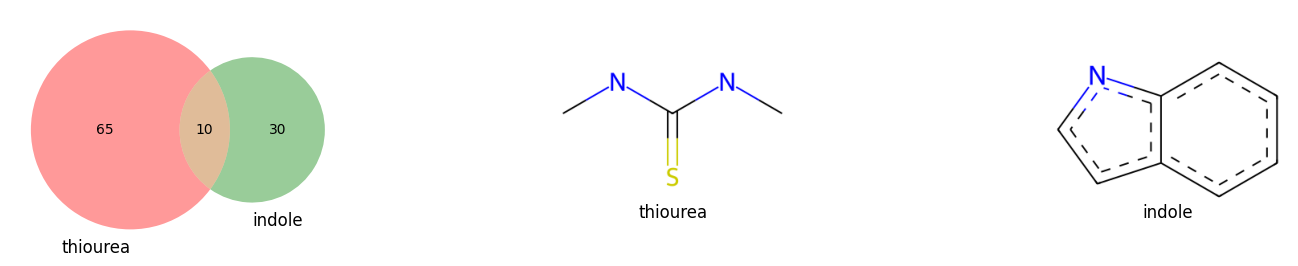

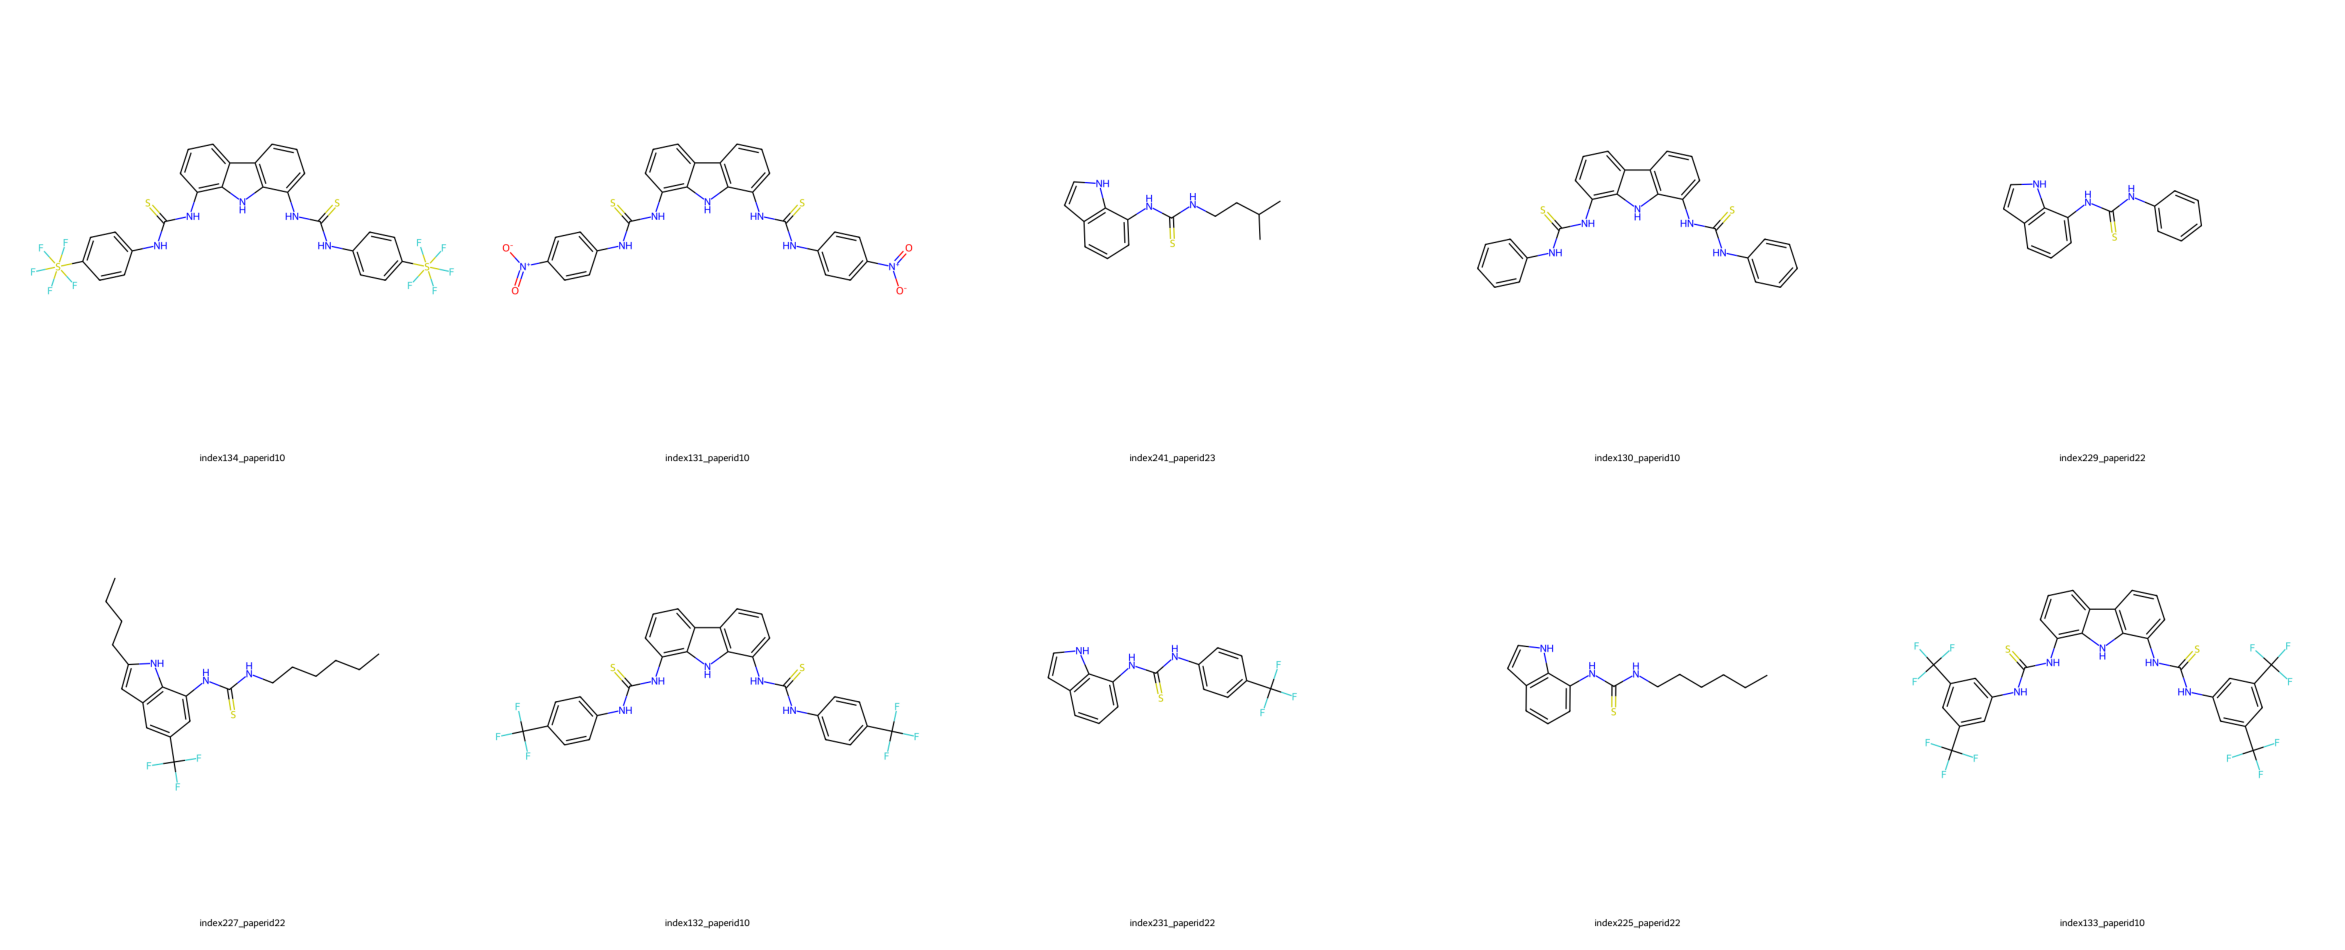

----------------------------------------------------------------------------------------
Intersect b/t thiourea and tambjamine: 0

----------------------------------------------------------------------------------------
Intersect b/t thiourea and carbazole: 5

Index of overlapped molecules:  [134, 131, 130, 132, 133]


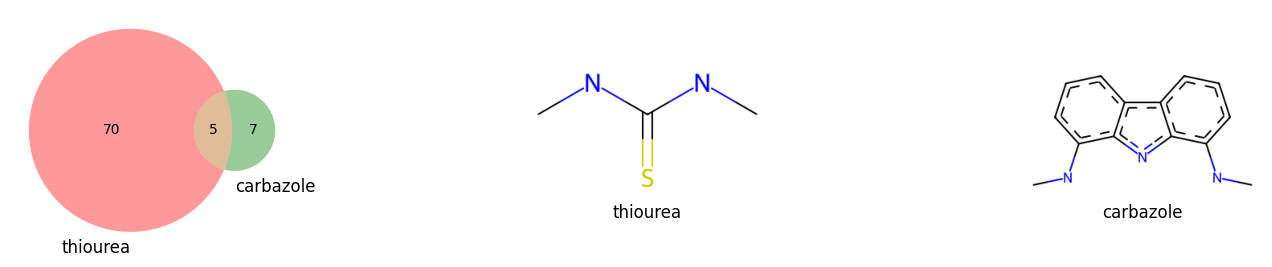

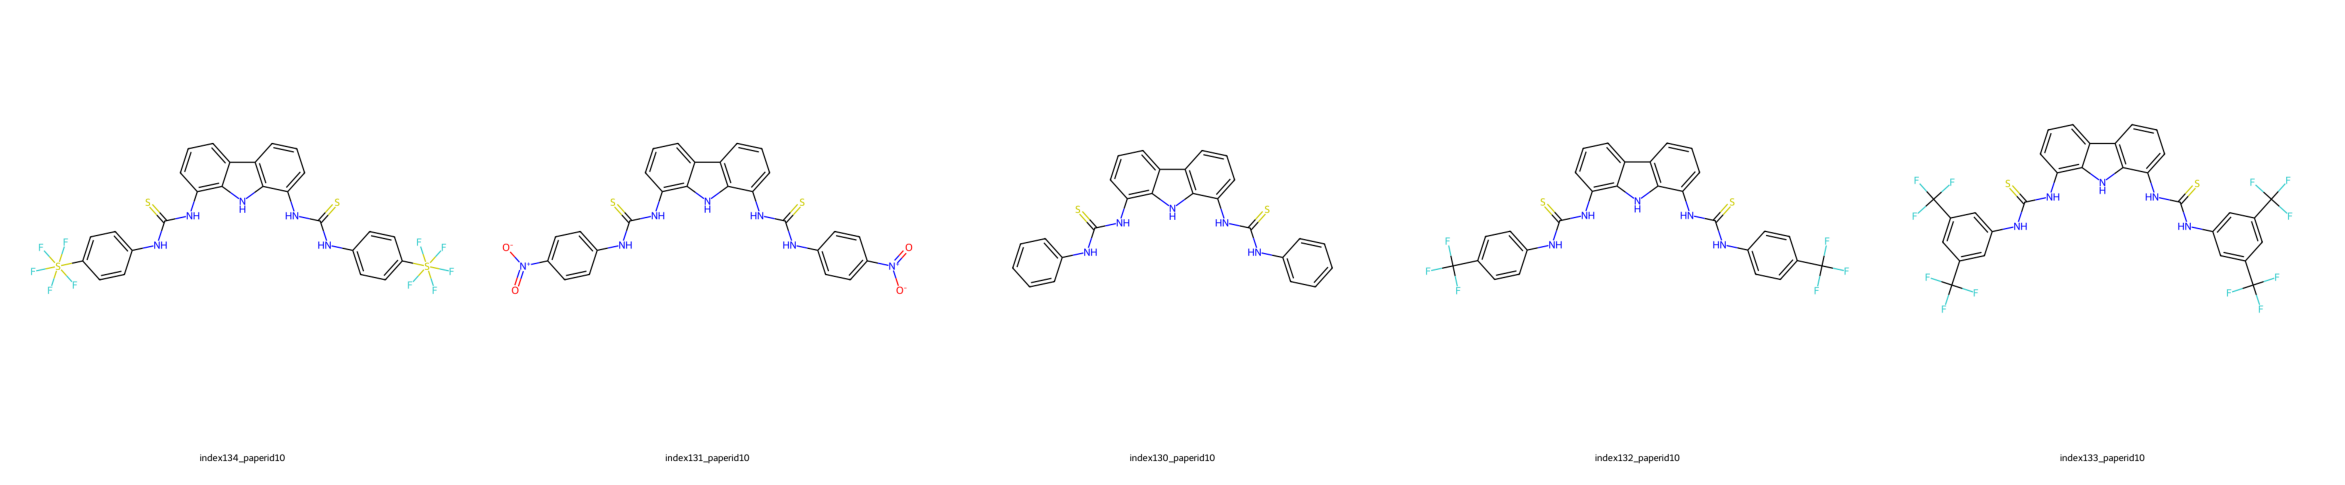

----------------------------------------------------------------------------------------
Intersect b/t thiourea and acridinone: 5

Index of overlapped molecules:  [142, 144, 143, 141, 140]


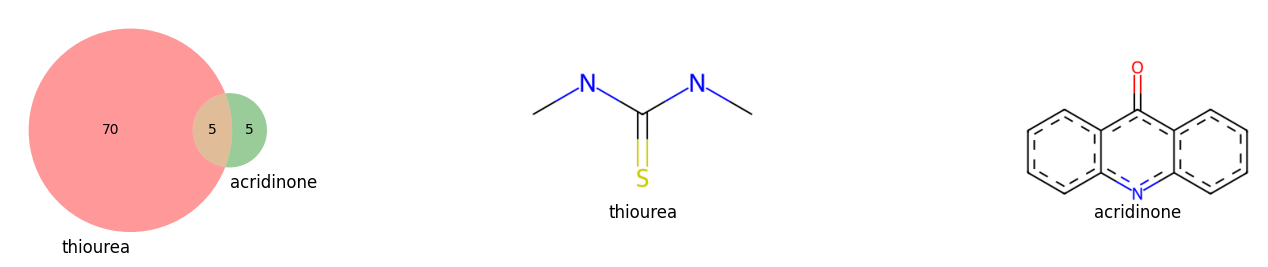

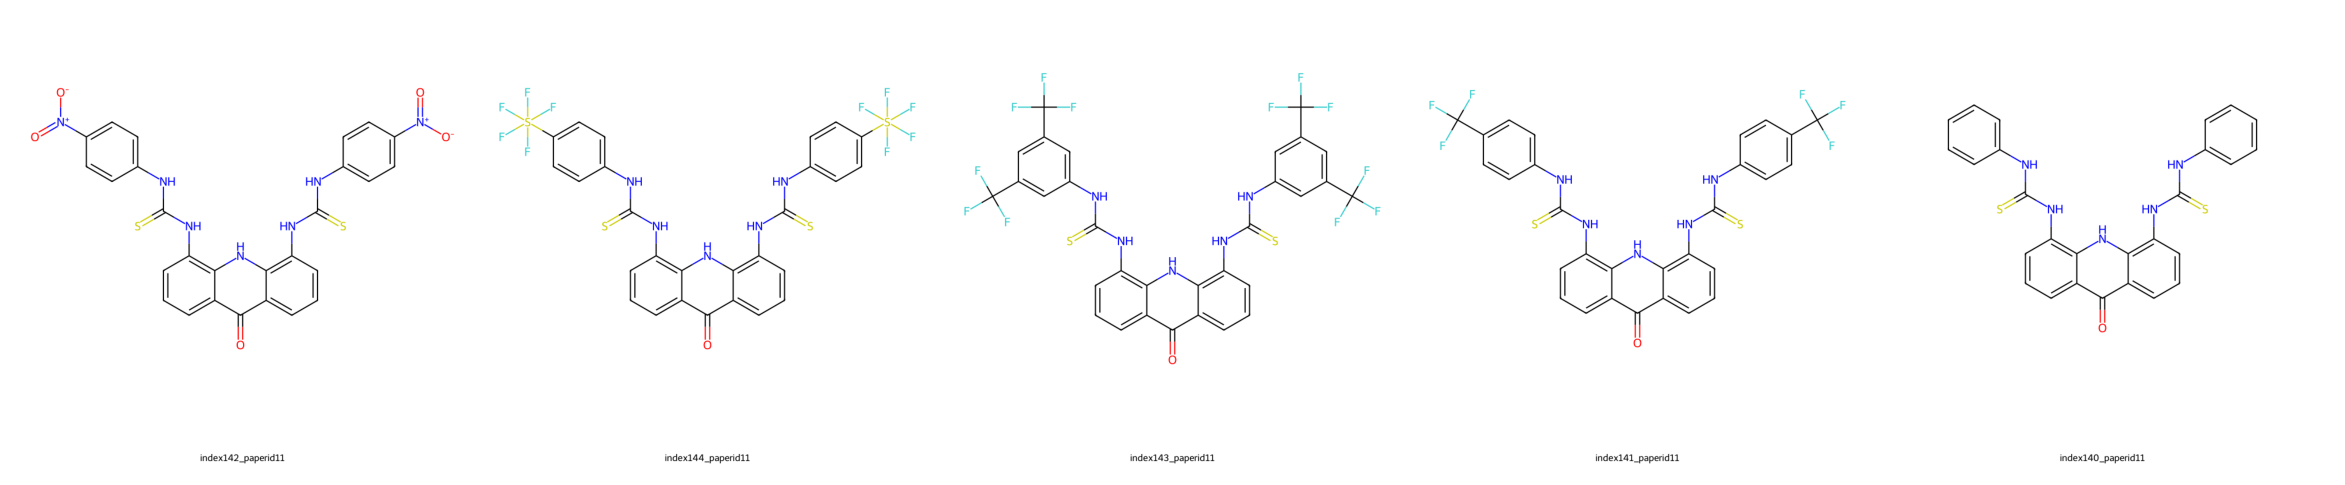

----------------------------------------------------------------------------------------
Intersect b/t thiourea and perenosin: 0

----------------------------------------------------------------------------------------
Intersect b/t thiourea and BisBzImPy: 0

----------------------------------------------------------------------------------------
Intersect b/t thiourea and isophthalamides/dipicolineamides: 0

----------------------------------------------------------------------------------------
Intersect b/t urea and squaramide: 0

----------------------------------------------------------------------------------------
Intersect b/t urea and indole: 16

Index of overlapped molecules:  [247, 246, 128, 245, 240, 242, 129, 230, 126, 125, 228, 243, 224, 226, 244, 127]


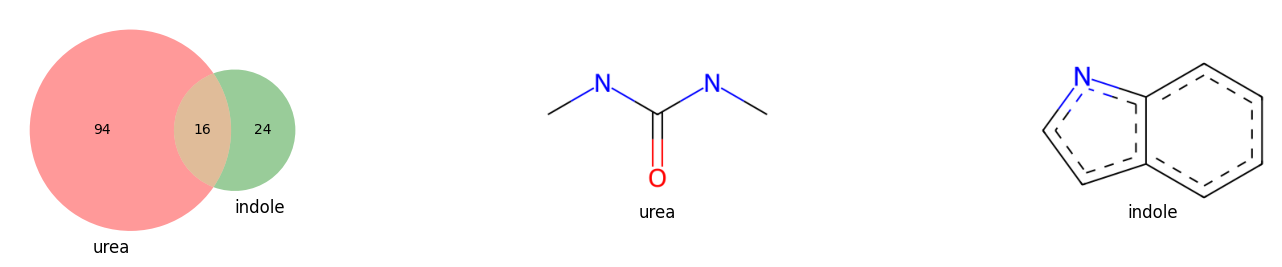

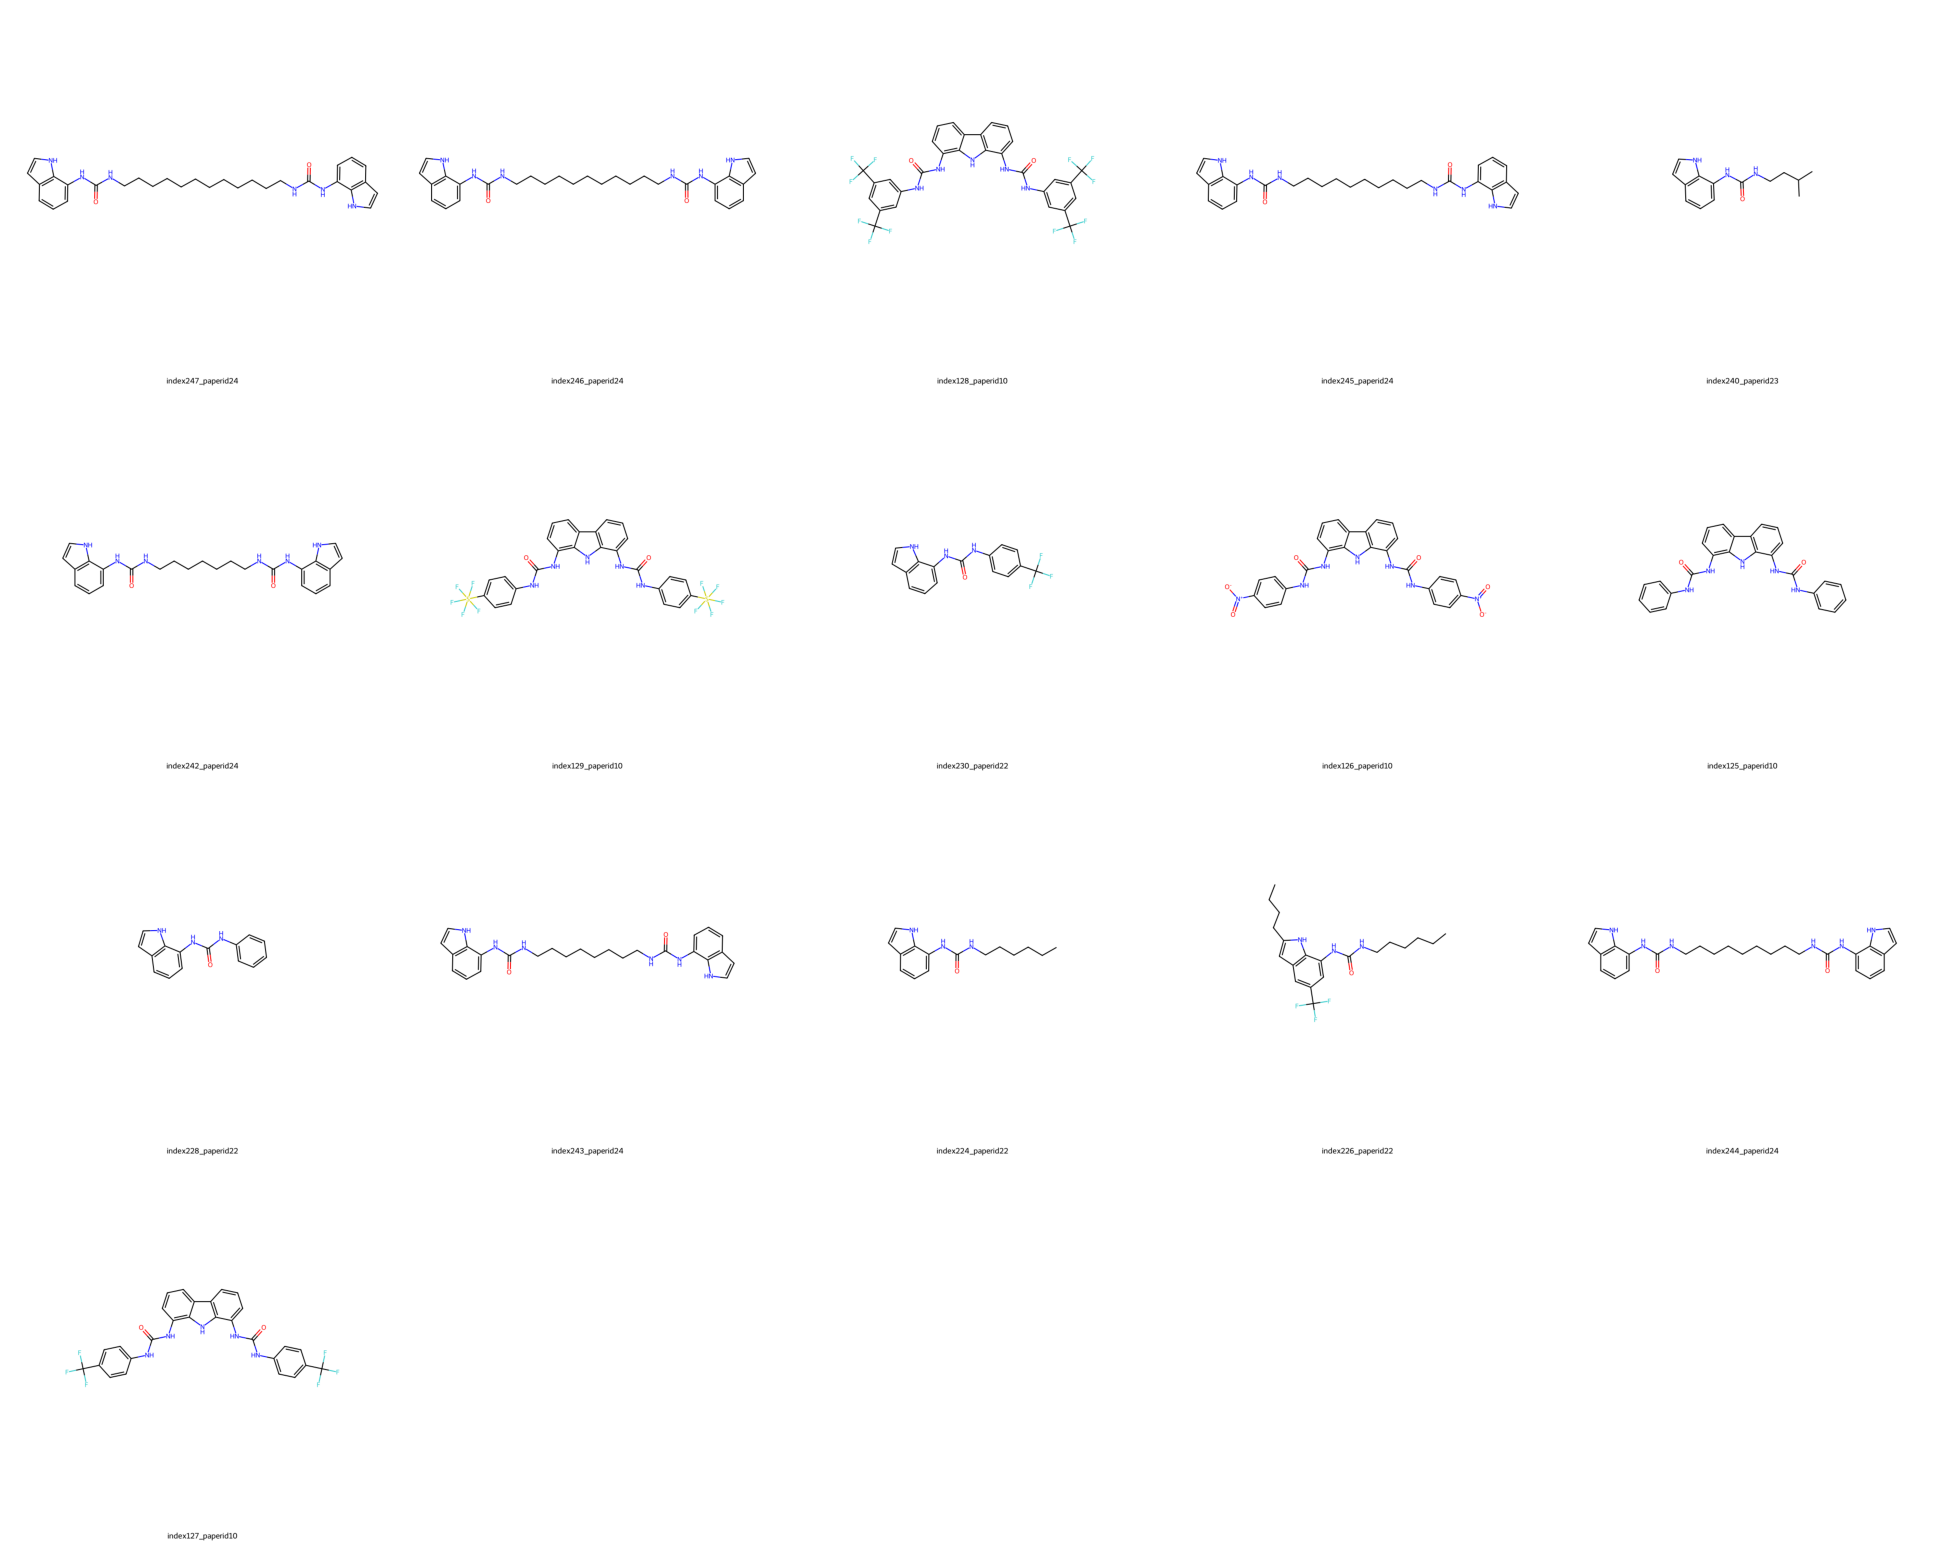

----------------------------------------------------------------------------------------
Intersect b/t urea and tambjamine: 0

----------------------------------------------------------------------------------------
Intersect b/t urea and carbazole: 5

Index of overlapped molecules:  [128, 129, 126, 125, 127]


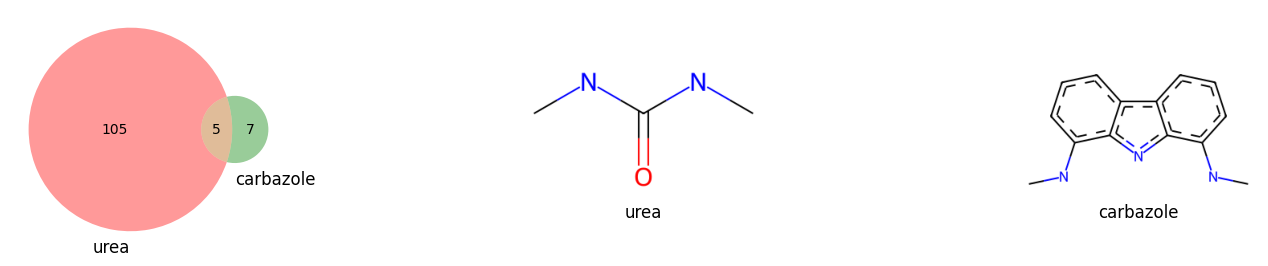

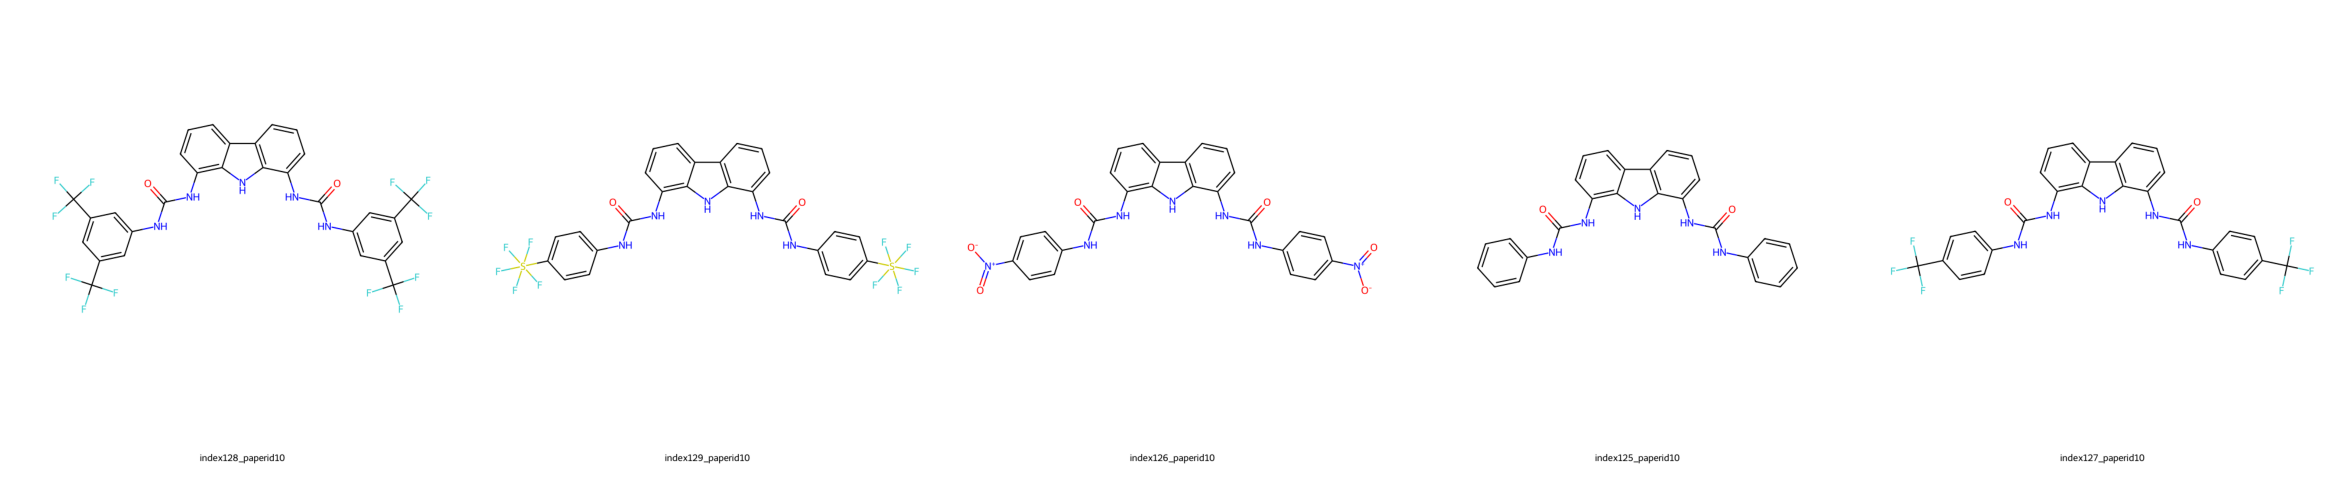

----------------------------------------------------------------------------------------
Intersect b/t urea and acridinone: 5

Index of overlapped molecules:  [135, 138, 139, 137, 136]


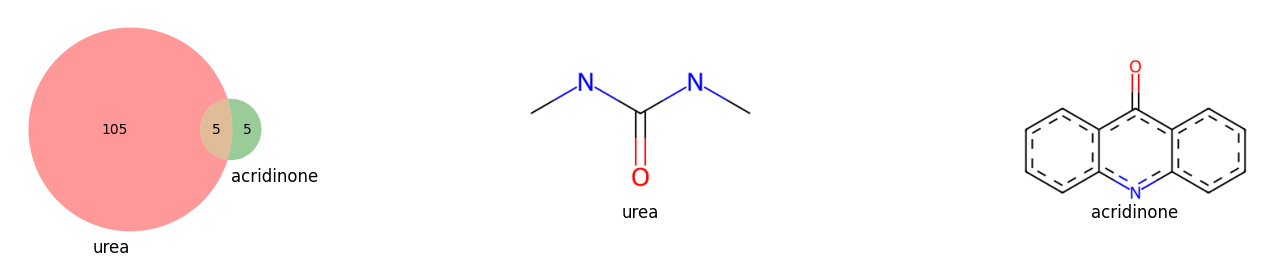

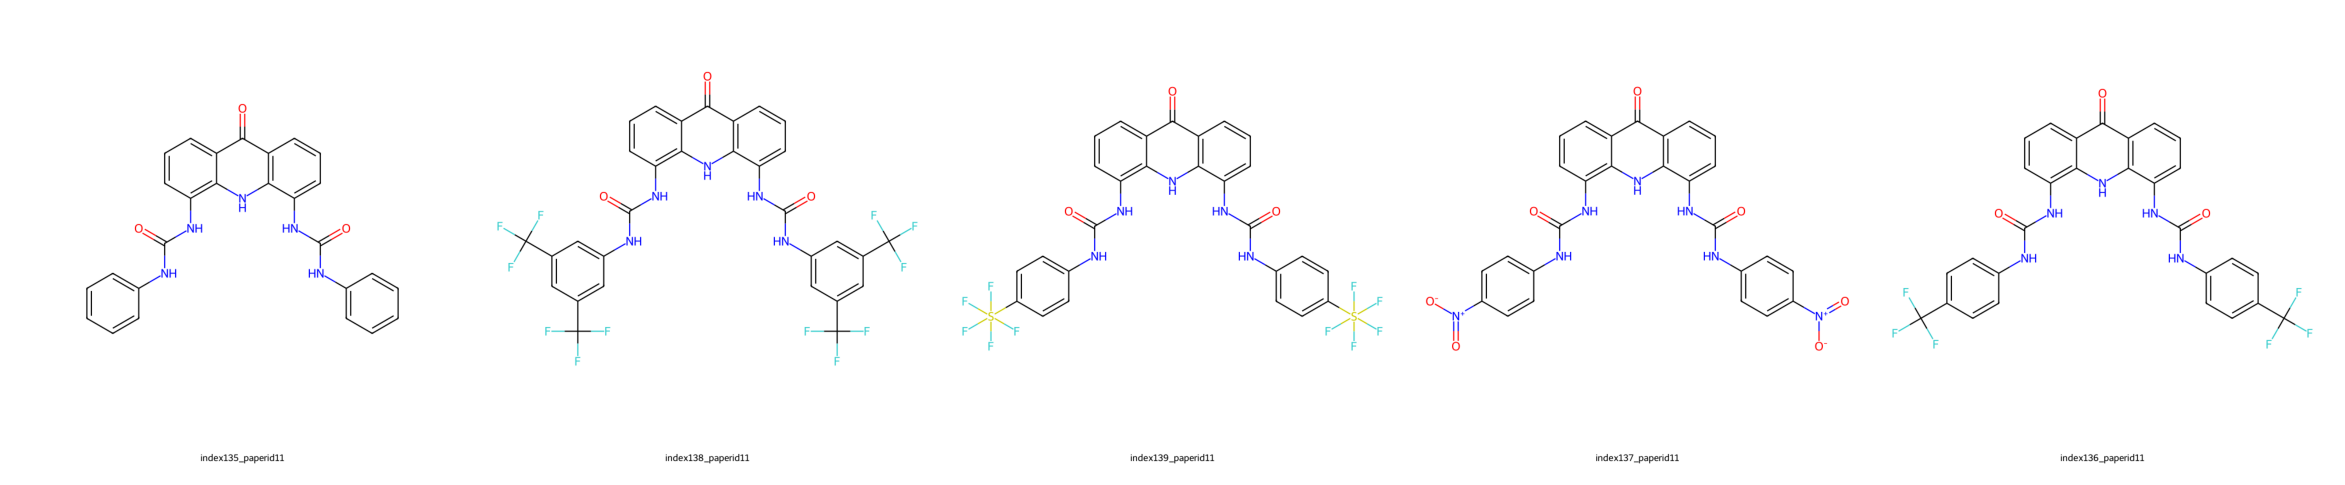

----------------------------------------------------------------------------------------
Intersect b/t urea and perenosin: 0

----------------------------------------------------------------------------------------
Intersect b/t urea and BisBzImPy: 0

----------------------------------------------------------------------------------------
Intersect b/t urea and isophthalamides/dipicolineamides: 0

----------------------------------------------------------------------------------------
Intersect b/t squaramide and indole: 0

----------------------------------------------------------------------------------------
Intersect b/t squaramide and tambjamine: 0

----------------------------------------------------------------------------------------
Intersect b/t squaramide and carbazole: 0

----------------------------------------------------------------------------------------
Intersect b/t squaramide and acridinone: 0

------------------------------------------------------------------------

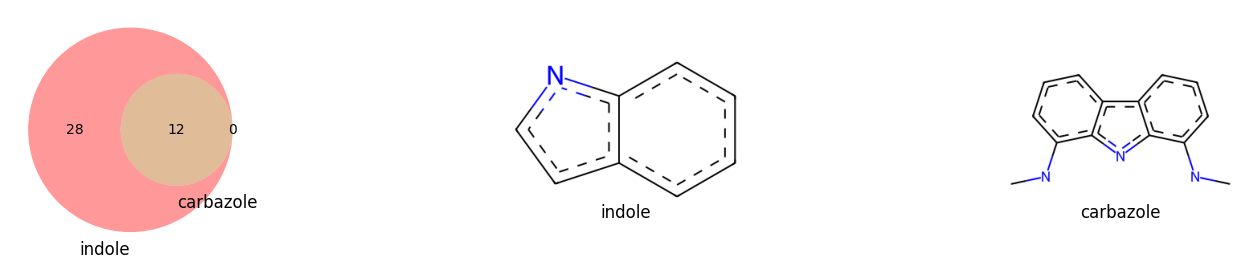

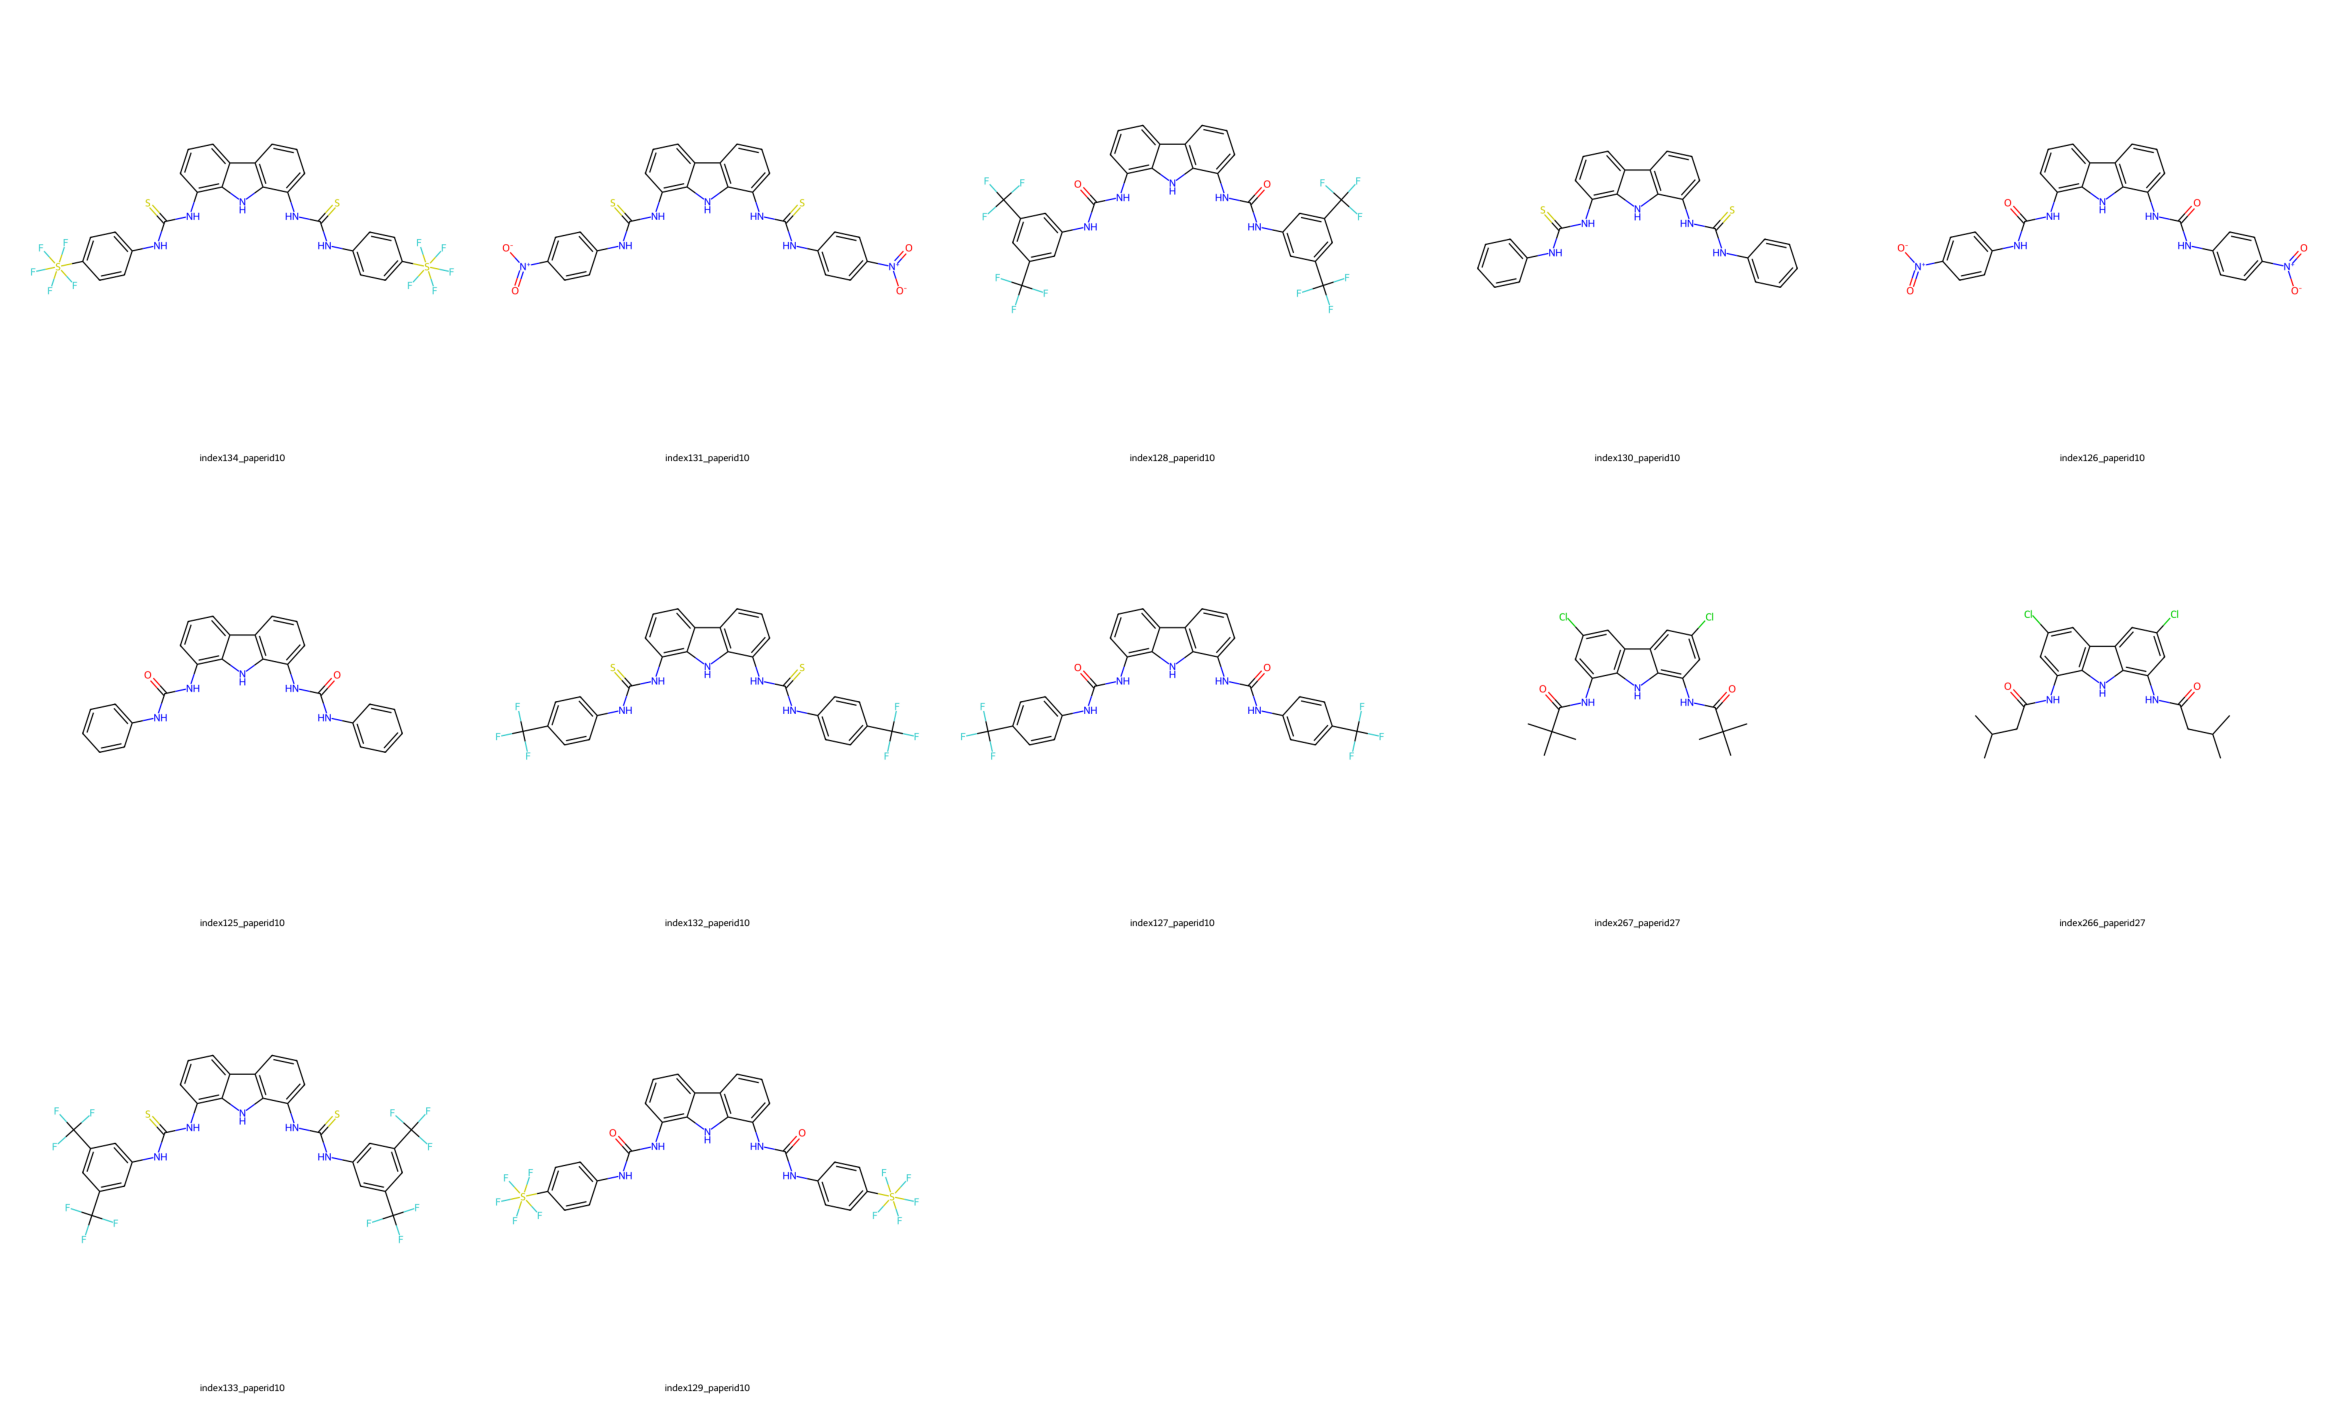

----------------------------------------------------------------------------------------
Intersect b/t indole and acridinone: 0

----------------------------------------------------------------------------------------
Intersect b/t indole and perenosin: 12

Index of overlapped molecules:  [171, 167, 184, 174, 186, 188, 170, 173, 185, 172, 169, 168]


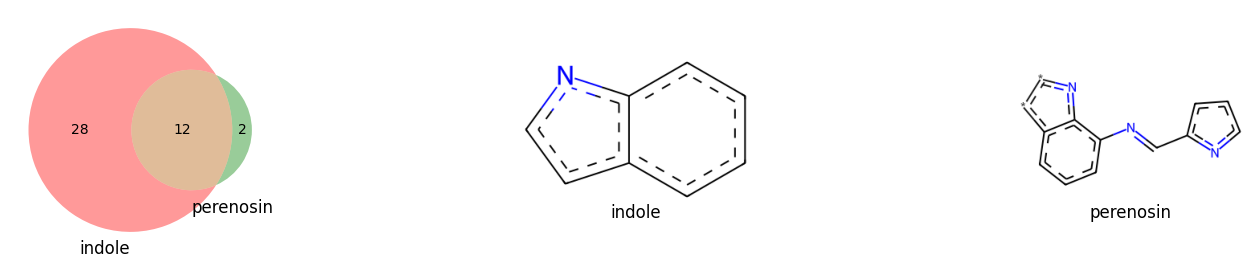

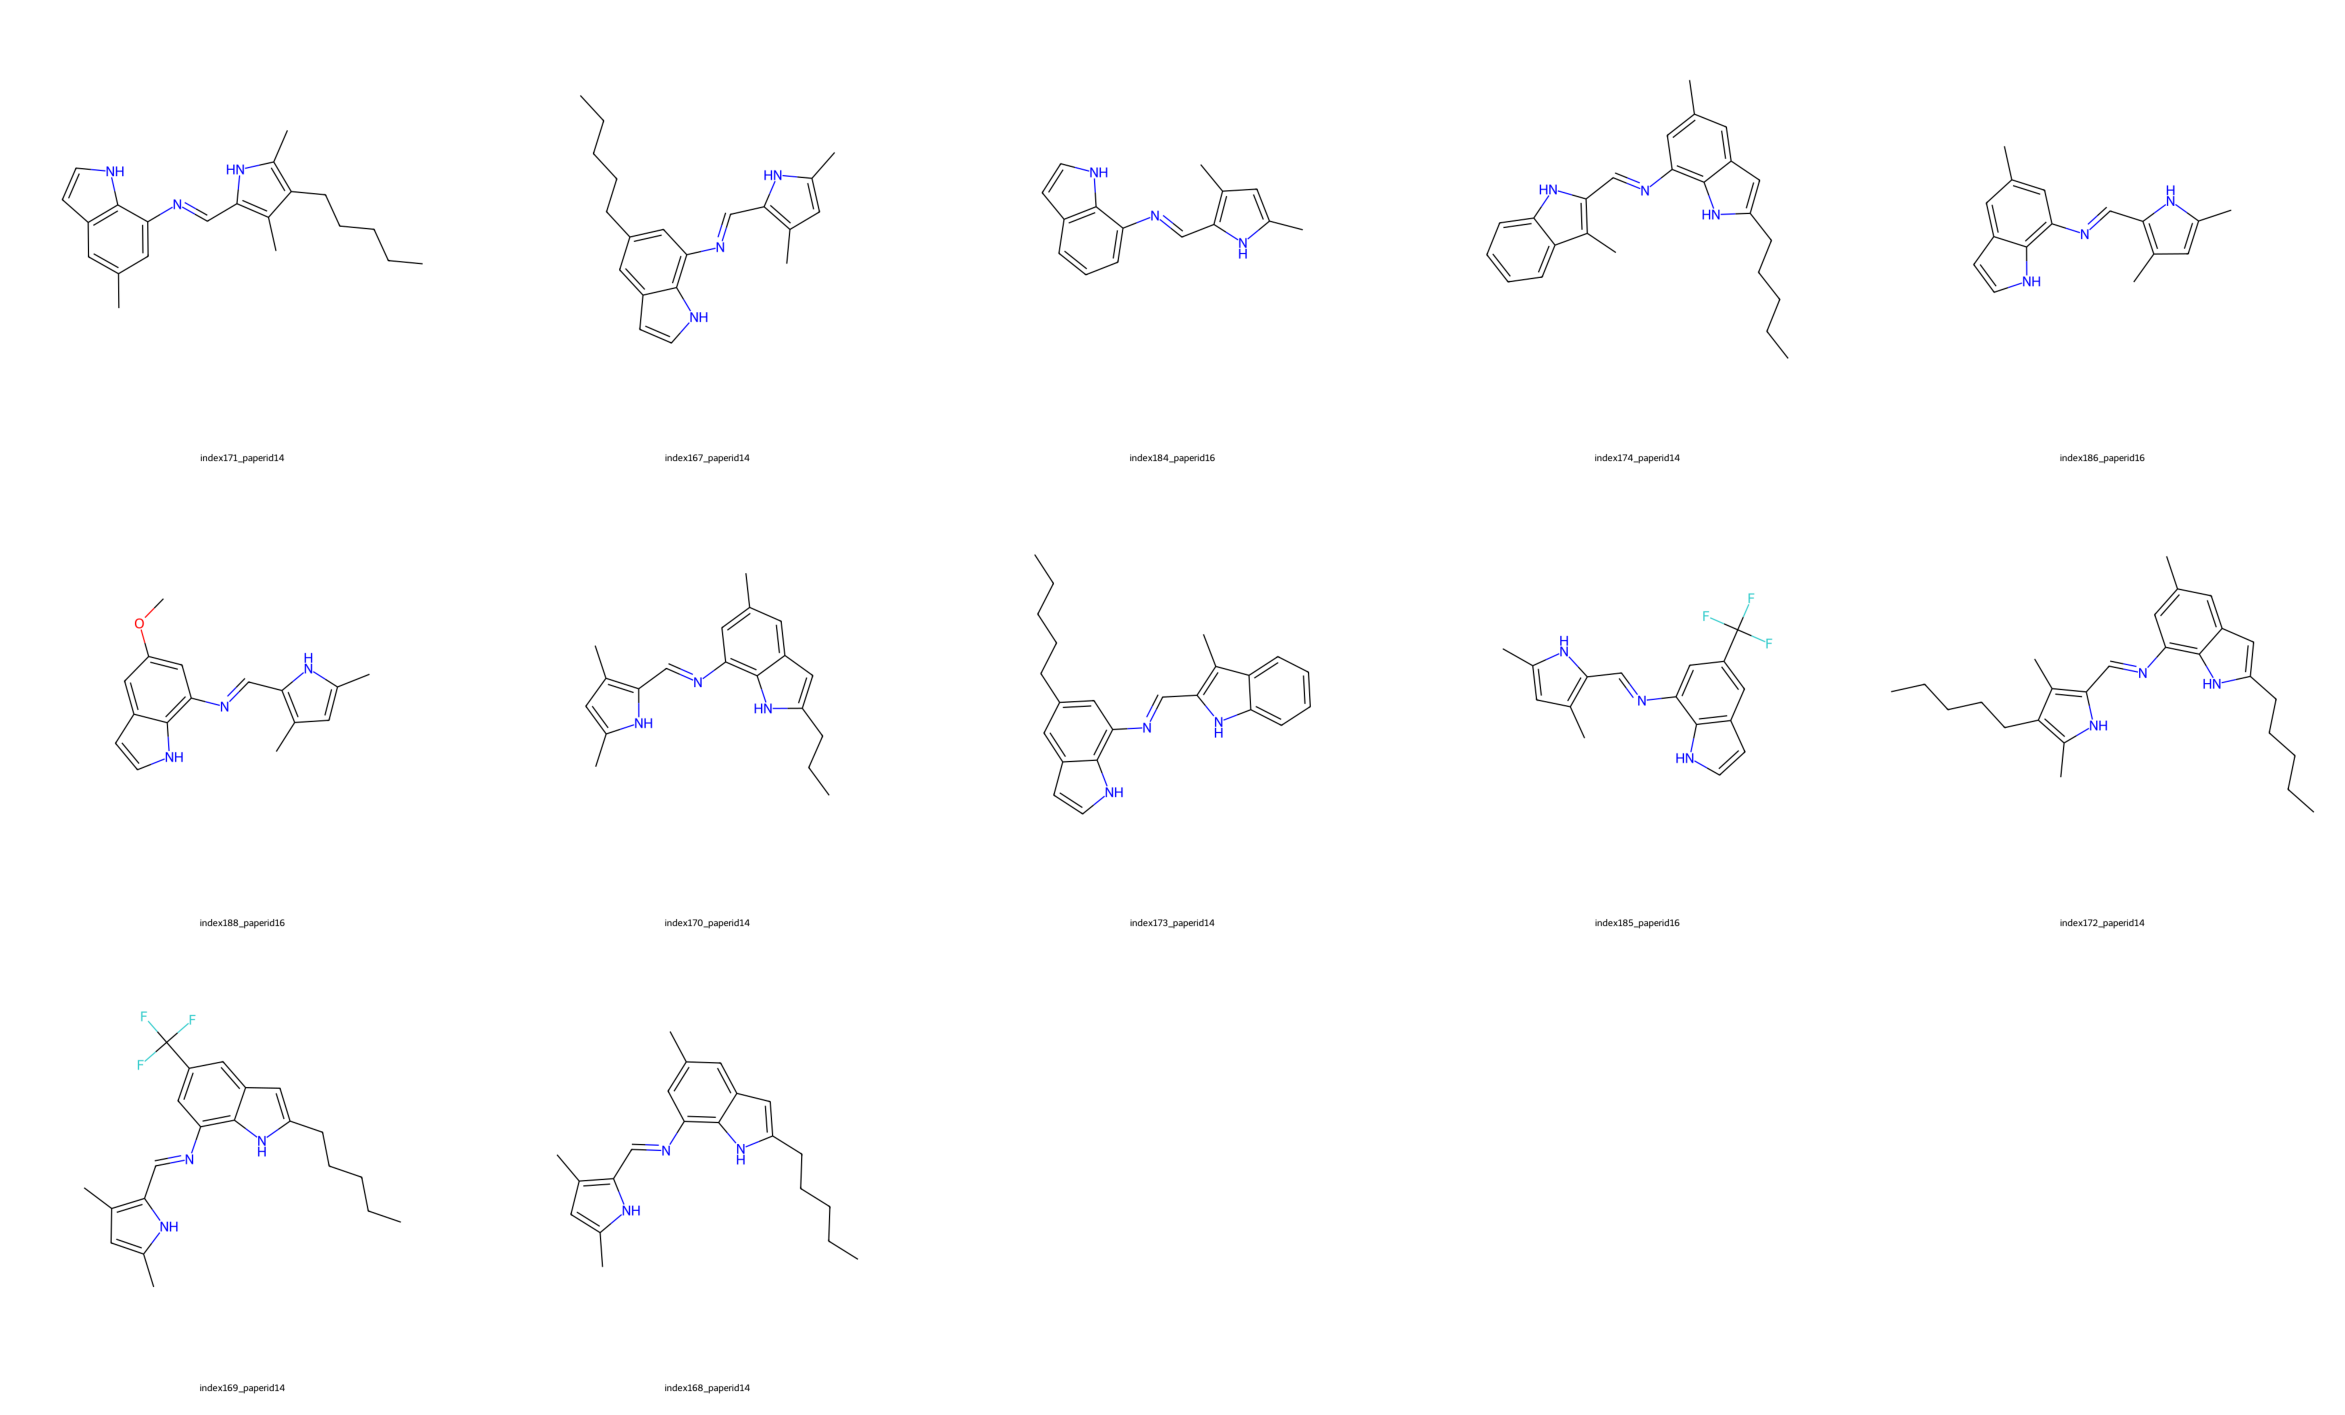

----------------------------------------------------------------------------------------
Intersect b/t indole and BisBzImPy: 0

----------------------------------------------------------------------------------------
Intersect b/t indole and isophthalamides/dipicolineamides: 0

----------------------------------------------------------------------------------------
Intersect b/t tambjamine and carbazole: 0

----------------------------------------------------------------------------------------
Intersect b/t tambjamine and acridinone: 0

----------------------------------------------------------------------------------------
Intersect b/t tambjamine and perenosin: 0

----------------------------------------------------------------------------------------
Intersect b/t tambjamine and BisBzImPy: 0

----------------------------------------------------------------------------------------
Intersect b/t tambjamine and isophthalamides/dipicolineamides: 0

-------------------------------------

In [46]:
# Find overlap between 2 sets of molecules with different substructure patterns
smiles_canonical = [Chem.MolToSmiles(m) for m in mols]
result_intersect = []
for i in range(n_substructure-1):
    for j in range(n_substructure):
        if j > i:
            #print(i,j)
            intersect_i = substructure_set_list[i].intersection(substructure_set_list[j])
            print('Intersect b/t ' + 
                  substructure_name_list[i] +' and ' + 
                  substructure_name_list[j] + ': ' + str(len(intersect_i)) + '\n')
            result_intersect.append(intersect_i)
            if len(intersect_i) != 0:
                
                im_i = Chem.Draw.MolToImage(substructure_core_list[i])
                im_j = Chem.Draw.MolToImage(substructure_core_list[j])
                
                mols_int = [Chem.MolFromSmiles(m) for m in intersect_i]
                mols_index = [(smiles_canonical.index(m)) for m in intersect_i]
                mols_paperid = [data['paperid'][m] for m in mols_index]
                mols_label = []
                for m in range(len(mols_index)):
                    lb = 'index' + str(mols_index[m]) + '_paperid' + str(mols_paperid[m])
                    mols_label.append(lb)
                print('Index of overlapped molecules: ', mols_index)
                im_overlap = Chem.Draw.MolsToGridImage(mols_int,molsPerRow=5, 
                                                       legends=[n for n in mols_label],
                                                       subImgSize=(800,800), returnPNG=False)
                
                im_name = 'fig_grid_overlap_' + substructure_name_list[i] + '_' + substructure_name_list[j] + '.png'
                im_overlap.save(im_name, figsize = (30, 20))
                
                
                fig, ax = plt.subplots(1,3, figsize = (15, 3))
                plt.tight_layout()
                
                v = venn2([substructure_set_list[i], substructure_set_list[j]], 
                       (substructure_name_list[i], substructure_name_list[j]), 
                          ax = ax[0])
                
                ax[1].imshow(im_i)
                ax[1].axis('off')
                ax[1].set_title(substructure_name_list[i], y=0.1)

                ax[2].imshow(im_j)
                ax[2].axis('off')
                ax[2].set_title(substructure_name_list[j], y=0.1)
                
                fig_name = 'fig_venn2_overlap_' + substructure_name_list[i] + '_' + substructure_name_list[j] + '.png'
                plt.savefig(fig_name)

                fig2, ax2 = plt.subplots(figsize=(30,20))
                ax2.axis('off')
                ax2.imshow(plt.imread(im_name))
                
                plt.show()
                print('----------------------------------------------------------------------------------------')
            else:
                print('----------------------------------------------------------------------------------------')
                

We can also find the overlap between any 3 substructure datasets.

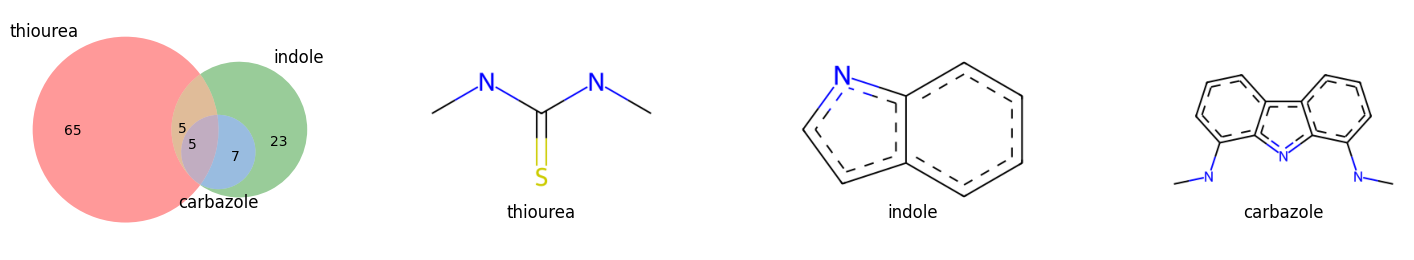

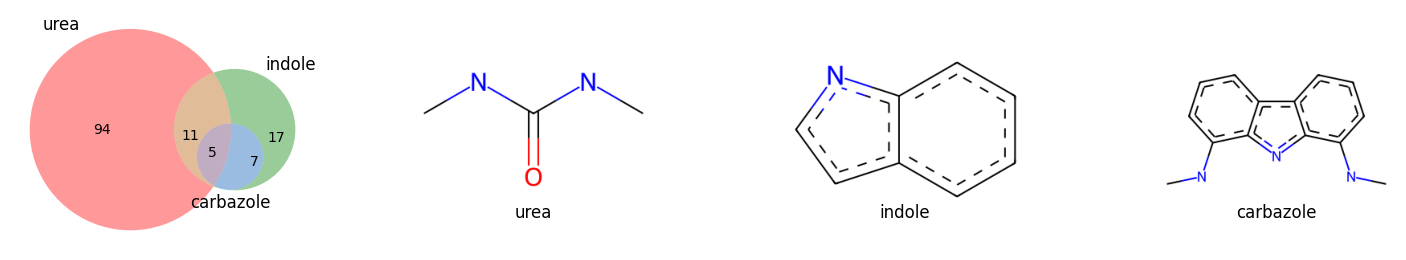

In [47]:
# Find overlap between 3 sets of molecules with different substructure patterns
result_intersect3 = []
for i in range(n_substructure-2):
    for j in range(n_substructure-1):
        for k in range(n_substructure):
            if k > j > i:
                intersect_i = substructure_set_list[i].intersection(substructure_set_list[j], substructure_set_list[k])
                result_intersect3.append(intersect_i)
                if len(intersect_i) != 0:
                    im_i = Chem.Draw.MolToImage(substructure_core_list[i])
                    im_j = Chem.Draw.MolToImage(substructure_core_list[j])
                    im_k = Chem.Draw.MolToImage(substructure_core_list[k])
                    
                    
                    fig, ax = plt.subplots(1,4, figsize = (15, 3))
                    plt.tight_layout()
                    
                    v = venn3([substructure_set_list[i], substructure_set_list[j], substructure_set_list[k]], 
                           (substructure_name_list[i], substructure_name_list[j], substructure_name_list[k]), 
                              ax = ax[0])
                    
                    ax[1].imshow(im_i)
                    ax[1].axis('off')
                    ax[1].set_title(substructure_name_list[i], y=0.1)

                    ax[2].imshow(im_j)
                    ax[2].axis('off')
                    ax[2].set_title(substructure_name_list[j], y=0.1)
                    
                    ax[3].imshow(im_k)
                    ax[3].axis('off')
                    ax[3].set_title(substructure_name_list[k], y=0.1)
                    
                    fig_name = 'fig_venn3_overlap_' + substructure_name_list[i] + '_' + substructure_name_list[j] + '_' + substructure_name_list[k] + '.png'
                    plt.savefig(fig_name)
                    
                    plt.show()
                    

# Tanimoto similarity in each substructure sets

In [48]:
# Convert list of RDKit molecules to list to morgan fingerprints
matches_thiourea_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_thiourea]
matches_urea_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_urea]
matches_squara_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_squara]
matches_indole_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_indole]
matches_tamb_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_tamb]
matches_carbazole_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_carbazole]
matches_acridinone_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_acridinone]
matches_pere_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_pere]
matches_BBP_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_BBP]
matches_isop_dipico_fps = [AllChem.GetMorganFingerprint(m,2) for m in matches_isop_dipico]

# List of lists of fps with each substructure pattern
substructure_fps_list = [matches_thiourea_fps, 
                         matches_urea_fps, 
                         matches_squara_fps, 
                         matches_indole_fps, 
                         matches_tamb_fps, 
                         matches_carbazole_fps, 
                         matches_acridinone_fps, 
                         matches_pere_fps,
                         matches_BBP_fps, 
                         matches_isop_dipico_fps]

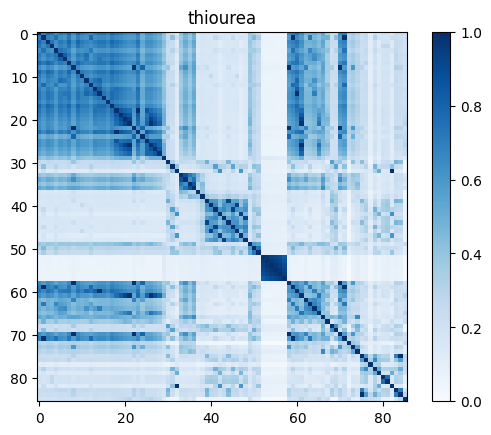

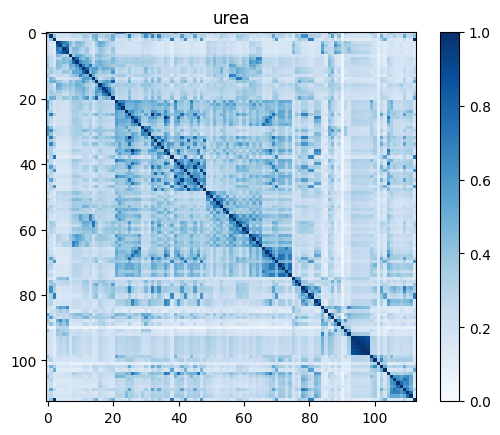

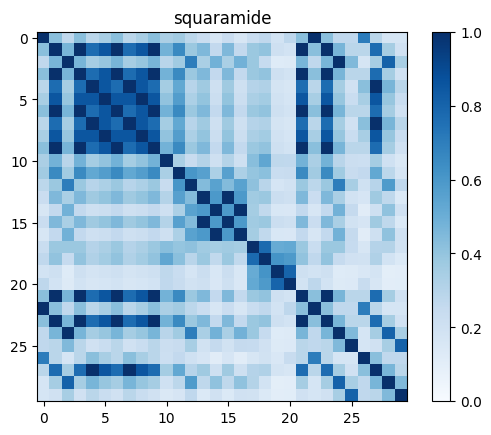

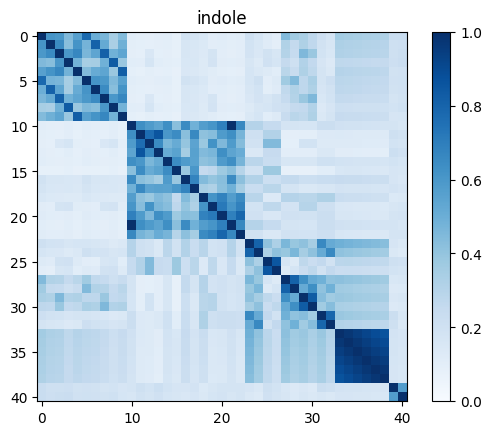

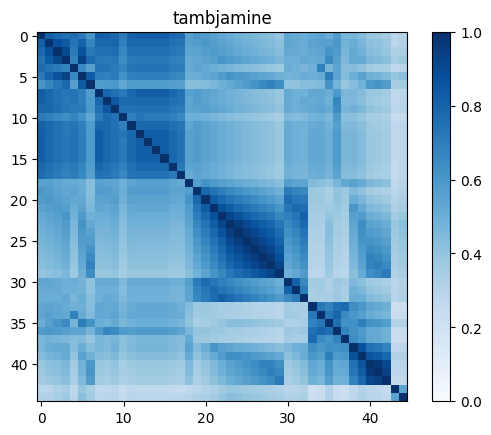

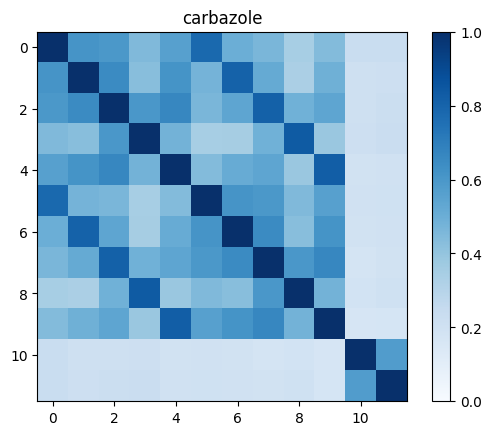

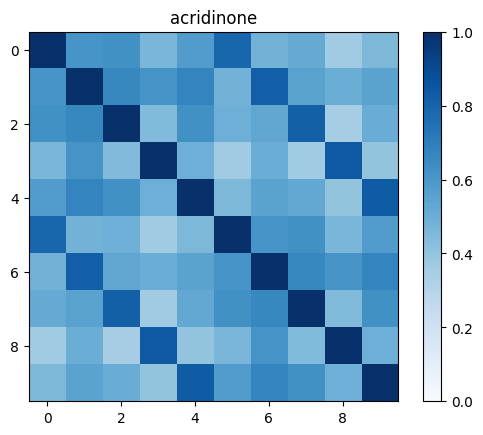

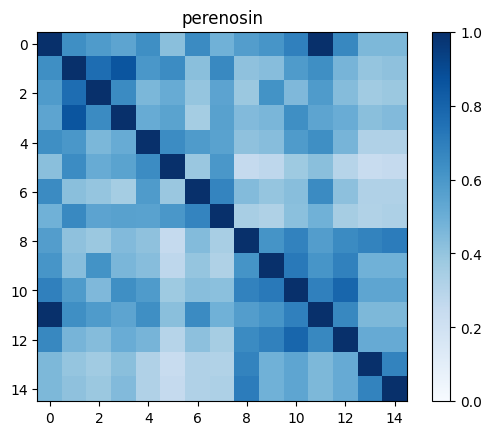

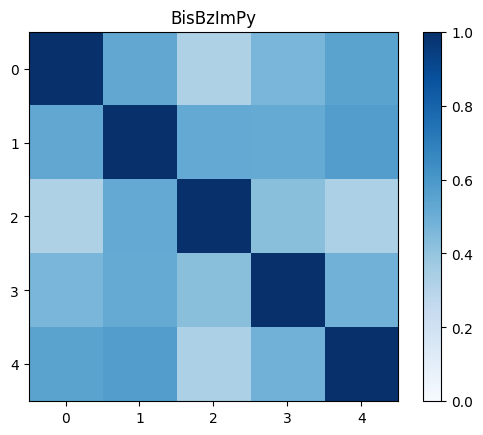

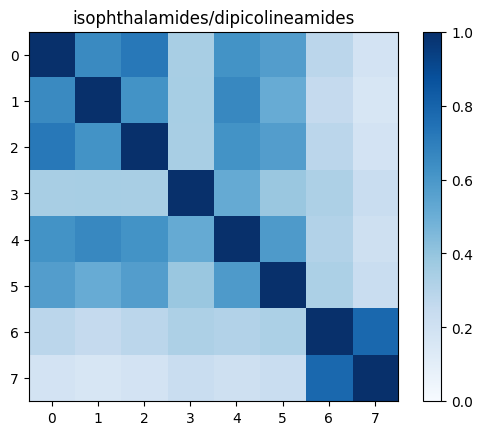

In [49]:
for i in range(n_substructure):
    fps = substructure_fps_list[i]
    similarity_array = np.zeros(shape=(len(fps), len(fps)))

    # compare all fp pairwise without duplicates
    for n, fp in enumerate(fps): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fp, fps)
        similarity_array[n, :] = np.array(s)
    
    im = plt.imshow(similarity_array,cmap='Blues')
    plt.colorbar(im, spacing = 'uniform')
    plt.clim(0, 1)
    plt.title(substructure_name_list[i])
    
    fig_name = 'fig_similarity_' + substructure_name_list[i][:4] + '.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

# One-hot encoding of substructure matches

One-hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [50]:
data['canonical_smiles'] = smiles_canonical

df = data.copy()
for n, l in substructure_dict.items():
    name = str(n.replace('/','_'))

    l_smi = [Chem.MolToSmiles(m) for m in l]

    df[name] = np.where(df["canonical_smiles"].isin(l_smi), "1", "0")

filename = 'df_all_substructure_onehot.csv'.format(name)
df.to_csv(filename)

print(df.columns)

df.head()

Index(['entry_in_paper', 'smiles', 'anion', 'binding_mode\n(transporter)',
       'binding_mode\n(anion)', 'stochiometry\n(#_of_anion_\nper_transporter)',
       'nmr_solvent', 'ka_(_m-1)', 'assay', 'lipid', 'measured_by',
       'cl_source_inside', 'cl_conc_(mm)', 'assay_ph',
       'time_between_transporter_added_and_lysis_(s)', 'ec50(mol%)_raw',
       'ec50(mol%)_target', 'hill_parameter_n', 'paperid', 'year', 'ref',
       'canonical_smiles', 'target', 'class', 'thiourea', 'urea', 'squaramide',
       'indole', 'tambjamine', 'carbazole', 'acridinone', 'perenosin',
       'BisBzImPy', 'isophthalamides_dipicolineamides'],
      dtype='object')


entry_in_paper                                   smiles anion  \
0              1             S=C(NCCCCCC)NC1=CC=C(Br)C=C1    Cl   
1              2       S=C(NCCCCCC)NC1=CC=C(C(F)(F)F)C=C1    Cl   
2              3             S=C(NCCCCCC)NC1=CC=C(Cl)C=C1    Cl   
3              4            S=C(NCCCCCC)NC1=CC=C(C#N)C=C1    Cl   
4              5  S=C(NCCCCCC)NC1=CC=C(C(C(F)(F)F)=O)C=C1    Cl   

   binding_mode\n(transporter)  binding_mode\n(anion)  \
0                          1.0                    1.0   
1                          1.0                    1.0   
2                          1.0                    1.0   
3                          1.0                    1.0   
4                          1.0                    1.0   

   stochiometry\n(#_of_anion_\nper_transporter) nmr_solvent ka_(_m-1)  \
0                                           1.0        DMSO     18.62   
1                                           1.0        DMSO      26.3   
2                                           1.0        DMSO     19.95   
3                                           1.0        DMSO     31.62   
4                                           1.0        DMSO     41.69   

      assay lipid  ... thiourea urea  squaramide  indole  tambjamine  \
0  Cl-/NO3-  POPC  ...        1    0           0       0           0   
1  Cl-/NO3-  POPC  ...        1    0           0       0           0   
2  Cl-/NO3-  POPC  ...        1    0           0       0           0   
3  Cl-/NO3-  POPC  ...        1    0           0       0           0   
4  Cl-/NO3-  POPC  ...        1    0           0       0           0   

   carbazole acridinone  perenosin  BisBzImPy  \
0          0          0          0          0   
1          0          0          0          0   
2          0          0          0          0   
3          0          0          0          0   
4          0          0          0          0   

   isophthalamides_dipicolineamides  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0  

[5 rows x 34 columns]

The new csv file **df_all_substructure_onehot.csv** is what we will use for ML.